# Assignment #2

- In this assignment, your goal is to implement advanced deep neural networks and train them with real-world datasets
- Specifically, you should fill the empty code block to successfully train the neural networks
- Each ToDo part will be designated with **Your Task** in the markdown, and you need fill the code within the block between *****START OF YOUR CODE (DO NOT DELETE/MODIFY THIS LINE)***** and *****End OF YOUR CODE (DO NOT DELETE/MODIFY THIS LINE)*****

In [1]:
import os
import random
import torch
import numpy as np
from builtins import range

# Part #0: Dataset Load

- In this assignment, we will consider image classification task as our target task
- Specifically, we will use CIFAR-10 dataset composed of 50000 32x32 real-world images across 10 different classes
- Below codes are written for loading CIFAR-10 dataset from pytorch. If you are hard to understand these, please re-study the basics of pytorch in https://d2l.ai/index.html

In [2]:
import matplotlib.pyplot as plt
import torch
import torchvision
from torchvision.datasets import CIFAR10
import statistics

plt.rcParams['figure.figsize'] = (10.0, 8.0)
plt.rcParams['font.size'] = 16

In [3]:
def _extract_tensors(dset, num=None, x_dtype=torch.float32):
    """
    Extract the data and labels from a CIFAR10 dataset object and convert them to
    tensors.

    Input:
    - dset: A torchvision.datasets.CIFAR10 object
    - num: Optional. If provided, the number of samples to keep.
    - x_dtype: Optional. data type of the input image

    Returns:
    - x: `x_dtype` tensor of shape (N, 3, 32, 32)
    - y: int64 tensor of shape (N,)
    """
    x = torch.tensor(dset.data, dtype=x_dtype)
    y = torch.tensor(dset.targets, dtype=torch.int64)
    if num is not None:
        if num <= 0 or num > x.shape[0]:
            raise ValueError(
                "Invalid value num=%d; must be in the range [0, %d]" % (num, x.shape[0])
            )
        x = x[:num].clone()
        y = y[:num].clone()
    return x, y

In [4]:
def cifar10(num_train=None, num_test=None, x_dtype=torch.float32):
    """
    Return the CIFAR10 dataset, automatically downloading it if necessary.
    This function can also subsample the dataset.

    Inputs:
    - num_train: [Optional] How many samples to keep from the training set.
      If not provided, then keep the entire training set.
    - num_test: [Optional] How many samples to keep from the test set.
      If not provided, then keep the entire test set.
    - x_dtype: [Optional] Data type of the input image

    Returns:
    - x_train: `x_dtype` tensor of shape (num_train, 3, 32, 32)
    - y_train: int64 tensor of shape (num_train, 3, 32, 32)
    - x_test: `x_dtype` tensor of shape (num_test, 3, 32, 32)
    - y_test: int64 tensor of shape (num_test, 3, 32, 32)
    """
    download = not os.path.isdir("cifar-10-batches-py")
    dset_train = CIFAR10(root=".", download=download, train=True)
    dset_test = CIFAR10(root=".", train=False)
    
    x_train, y_train = _extract_tensors(dset_train, num_train, x_dtype)
    x_test, y_test = _extract_tensors(dset_test, num_test, x_dtype)

    return x_train, y_train, x_test, y_test

In [5]:
def get_CIFAR10_data(num_train=49000, num_val=1000, num_test=1000, num_dev=500):
    """
    Load the CIFAR-10 dataset from disk and perform preprocessing to prepare it for the linear classifier. 
    """
    # Load the raw CIFAR-10 data
    x_trainval, y_trainval, x_test, y_test = cifar10(num_train + num_val, num_test)
    
    # Subsample the data
    mask = list(range(num_train, num_train + num_val))
    x_val = x_trainval[mask]
    y_val = y_trainval[mask]
    mask = list(range(num_train))
    x_train = x_trainval[mask]
    y_train = y_trainval[mask]
    mask = np.random.choice(num_train, num_dev, replace=False)
    x_dev = x_train[mask]
    y_dev = y_train[mask]
    
    # Preprocessing: reshape the image data into rows
    x_train = torch.reshape(x_train, (x_train.shape[0], -1))
    x_val = torch.reshape(x_val, (x_val.shape[0], -1))
    x_test = torch.reshape(x_test, (x_test.shape[0], -1))
    x_dev = torch.reshape(x_dev, (x_dev.shape[0], -1))
    
    # Normalize the data: subtract the mean image
    mean_image = torch.mean(x_train, axis = 0)
    x_train -= mean_image
    x_val -= mean_image
    x_test -= mean_image
    x_dev -= mean_image
    
    # add bias dimension and transform into columns
    x_train = torch.cat([x_train, torch.ones((x_train.shape[0], 1))], dim=-1)
    x_val = torch.cat([x_val, torch.ones((x_val.shape[0], 1))], dim=-1)
    x_test = torch.cat([x_test, torch.ones((x_test.shape[0], 1))], dim=-1)
    x_dev = torch.cat([x_dev, torch.ones((x_dev.shape[0], 1))], dim=-1)
    
    return x_train, y_train, x_val, y_val, x_test, y_test, x_dev, y_dev

# Invoke the above function to get our data.
x_train, y_train, x_val, y_val, x_test, y_test, x_dev, y_dev = get_CIFAR10_data()
print('Train data shape: ', x_train.shape)
print('Train labels shape: ', y_train.shape)
print('Validation data shape: ', x_val.shape)
print('Validation labels shape: ', y_val.shape)
print('Test data shape: ', x_test.shape)
print('Test labels shape: ', y_test.shape)
print('dev data shape: ', x_dev.shape)
print('dev labels shape: ', y_dev.shape)

Train data shape:  torch.Size([49000, 3073])
Train labels shape:  torch.Size([49000])
Validation data shape:  torch.Size([1000, 3073])
Validation labels shape:  torch.Size([1000])
Test data shape:  torch.Size([1000, 3073])
Test labels shape:  torch.Size([1000])
dev data shape:  torch.Size([500, 3073])
dev labels shape:  torch.Size([500])


In [6]:
data = {"X_train": x_train, "y_train": y_train, "X_val": x_val, "y_val": y_val, "X_test": x_test, "y_test": y_test}

# Part #1: Implementation of Simple Neural Network
- Now, let's start to implement 'deeper' neural network.
- You will first work on implementing N-layers neural network with softmax loss

## N-layer Deep Neural Network with Non-linear Activation

### Linear layer
- **Your task #1**: Implement the forward pass of linear layer. Store the result in out. You will need to reshape the input into rows.

In [7]:
def linear_forward(x, w, b):
    """
    Computes the forward pass for a linear (fully-connected) layer.

    The input x has shape (N, d_1, ..., d_k) and contains a minibatch of N
    examples, where each example x[i] has shape (d_1, ..., d_k). We will
    reshape each input into a vector of dimension D = d_1 * ... * d_k, and
    then transform it to an output vector of dimension M.

    Inputs:
    - x: A tensor containing input data, of shape (N, d_1, ..., d_k)
    - w: A tensor of weights, of shape (D, M)
    - b: A tensor of biases, of shape (M,)

    Returns a tuple of:
    - out: output, of shape (N, M)
    - cache: (x, w, b)
    """
    out = None
    # Your task #1
    # *****START OF YOUR CODE (DO NOT DELETE/MODIFY THIS LINE)*****
    # Reshape x to (N, D)
    N = x.shape[0]
    D = w.shape[0]
    x_reshaped = x.reshape(N, D)
    
    # Compute the forward pass
    out = torch.mm(x_reshaped.to(torch.float32), w.to(torch.float32)) + b

    # *****END OF YOUR CODE (DO NOT DELETE/MODIFY THIS LINE)*****
    cache = (x, w, b)
    return out, cache

**Your task #2**: Implement the backward pass of linear layer. 

In [8]:
def linear_backward(dout, cache):
    """
    Computes the backward pass for a linear layer.

    Inputs:
    - dout: Upstream derivative, of shape (N, M)
    - cache: Tuple of:
      - x: Input data, of shape (N, d_1, ... d_k)
      - w: Weights, of shape (D, M)
      - b: Biases, of shape (M,)

    Returns a tuple of:
    - dx: Gradient with respect to x, of shape (N, d1, ..., d_k)
    - dw: Gradient with respect to w, of shape (D, M)
    - db: Gradient with respect to b, of shape (M,)
    """
    x, w, b = cache
    dx, dw, db = None, None, None

    # Your task #2
    # *****START OF YOUR CODE (DO NOT DELETE/MODIFY THIS LINE)*****
    # Reshape x to (N, D)
    N = x.shape[0]
    D = w.shape[0]
    x_reshaped = x.reshape(N, D)
    
    # Compute gradients
    dx_reshaped = torch.mm(dout.to(torch.float32), w.T.to(torch.float32))  # Gradient with respect to reshaped x
    dw = torch.mm(x_reshaped.T.to(torch.float32), dout.to(torch.float32))  # Gradient with respect to weights
    db = torch.sum(dout, dim=0)        # Gradient with respect to biases 

    # Reshape dx back to (N, d_1, ..., d_k)
    dx = dx_reshaped.reshape(x.shape)
    
    # *****END OF YOUR CODE (DO NOT DELETE/MODIFY THIS LINE)*****
    
    return dx, dw, db

### ReLU layer
- **Your task #3**: Implement ReLU activation layer. Store the result in out. 

In [9]:
def relu_forward(x):
    """
    Computes the forward pass for a layer of rectified linear units (ReLUs).

    Input:
    - x: Inputs, of any shape

    Returns a tuple of:
    - out: Output, of the same shape as x
    - cache: x
    """
    out = None

    # Your task #3
    # *****START OF YOUR CODE (DO NOT DELETE/MODIFY THIS LINE)*****
    # Element-wise ReLU
    out = torch.maximum(torch.zeros(size=x.shape), x) 
    # *****END OF YOUR CODE (DO NOT DELETE/MODIFY THIS LINE)*****
    
    cache = x
    return out, cache

**Your task #4**: Implement the backward pass of ReLU activation layer. 

In [10]:
def relu_backward(dout, cache):
    """
    Computes the backward pass for a layer of rectified linear units (ReLUs).

    Input:
    - dout: Upstream derivatives, of any shape
    - cache: Input x, of same shape as dout

    Returns:
    - dx: Gradient with respect to x
    """
    dx, x = None, cache

    # Your task #4
    # *****START OF YOUR CODE (DO NOT DELETE/MODIFY THIS LINE)*****
    # Compute the gradient
    dx = dout * (x > 0)
    # *****END OF YOUR CODE (DO NOT DELETE/MODIFY THIS LINE)*****
    
    return dx

### Softmax Layer
**Your task #5**: Implement the loss and gradient for softmax classification. 

In [11]:
def softmax_loss(x, y):
    """
    Computes the loss and gradient for softmax classification.

    Inputs:
    - x: Input data, of shape (N, C) where x[i, j] is the score for the jth
      class for the ith input.
    - y: Vector of labels, of shape (N,) where y[i] is the label for x[i] and
      0 <= y[i] < C

    Returns a tuple of:
    - loss: Scalar giving the loss
    - dx: Gradient of the loss with respect to x
    """
    loss, dx = None, None

    # Your task #5
    # *****START OF YOUR CODE (DO NOT DELETE/MODIFY THIS LINE)*****
    # Number of samples
    N = x.shape[0]

    # Compute shifted logits for numerical stability
    shifted_logits = x - torch.max(x, dim=1, keepdim=True).values
    
    # Compute softmax probabilities
    exp_logits = torch.exp(shifted_logits)
    softmax_probs = exp_logits / torch.sum(exp_logits, dim=1, keepdim=True)
    
    # Compute loss
    correct_class_probs = softmax_probs[torch.arange(N), y]
    loss = -torch.mean(torch.log(correct_class_probs))

    # Compute gradient
    dx = softmax_probs.clone()
    dx[torch.arange(N), y] -= 1
    dx /= N
    
    # *****END OF YOUR CODE (DO NOT DELETE/MODIFY THIS LINE)*****
    
    return loss, dx

### Combining these layers for generic implementation

In [12]:
def generic_forward(x, w, b, last=False):
    """Convenience layer composed of linear layer and ReLU activation

    Inputs:
    - x: Input to the linear layer
    - w, b: Weights for the linear layer
    - last: Indicates wether to perform just linear layer without ReLU (e.g., last layer)

    Returns a tuple of:
    - out: Output from the ReLU
    - cache: Object to give to the backward pass
    """
    # Initialize optional caches to None
    relu_cache = None

    # Linear forward is a must
    out, fc_cache = linear_forward(x, w, b)

    # If the the layer is not last
    if not last:
        # Pass the outputs through activation
        out, relu_cache = relu_forward(out) # perform relu

    # Prepare cache for backward pass
    cache = fc_cache, relu_cache

    return out, cache

In [13]:
def generic_backward(dout, cache):
    """Backward pass for the linear-relu layers.
    """
    # Get the prapared caches from the forward pass
    fc_cache, relu_cache = cache

    # If relu was performed
    if relu_cache is not None:
        dout = relu_backward(dout, relu_cache)

    # Linear backward is a must
    dx, dw, db = linear_backward(dout, fc_cache)

    return dx, dw, db

- **Your task #6 (Initialization)**: Initialize the parameters of the network, storing all values in the self.params dictionary. Store weights and biases for the first layer in W1 and b1; for the second layer use W2 and b2, etc. Weights should be initialized from a normal distribution centered at 0 with standard deviation equal to weight_scale. Biases should be initialized to zero.

- **Your task #7 (Forward)**: Implement the forward pass for the fully connected net, computing the class scores for X and storing them in the scores variable.   

- **Your task #8 (Backward)**: Implement the backward pass for the fully connected net. Store the loss in the loss variable and gradients in the grads dictionary. Compute data loss using softmax, and make sure that grads[k] holds the gradients for self.params[k]. Don't forget to add L2 regularization. Caution. To ensure that your implementation matches ours and you pass the automated tests, make sure that your L2 regularization includes a factor of 0.5 to simplify the expression for the gradient.

In [14]:
class FullyConnectedNet(object):
    """Class for a multi-layer fully connected neural network.

    Network contains an arbitrary number of hidden layers, ReLU nonlinearities,
    and a softmax loss function. For a network with L layers, the architecture will be

    {Linear - relu} x (L - 1) - Linear - softmax

    where the {...} block is repeated L - 1 times. Learnable parameters are stored in the self.params dictionary and will be learned
    using the Solver class.
    """

    def __init__(
        self,
        hidden_dims,
        input_dim=3 * 32 * 32 + 1,
        num_classes=10,
        reg=0.0,
        weight_scale=1e-2,
        dtype=np.float32,
    ):
        """Initialize a new FullyConnectedNet.

        Inputs:
        - hidden_dims: A list of integers giving the size of each hidden layer.
        - input_dim: An integer giving the size of the input.
        - num_classes: An integer giving the number of classes to classify.
        - reg: Scalar giving L2 regularization strength.
        - weight_scale: Scalar giving the standard deviation for random
            initialization of the weights.
        - dtype: A numpy datatype object; all computations will be performed using
            this datatype. float32 is faster but less accurate, so you should use
            float64 for numeric gradient checking.
        """
        self.reg = reg
        self.num_layers = 1 + len(hidden_dims)
        self.dtype = dtype
        self.params = {}

        # Your task #6
        # *****START OF YOUR CODE (DO NOT DELETE/MODIFY THIS LINE)*****
        # Initialize weights and biases
        layer_input_dim = input_dim
        for i, hidden_dim in enumerate(hidden_dims):
            self.params[f'W{i+1}'] = weight_scale * torch.randn(layer_input_dim, hidden_dim)
            self.params[f'b{i+1}'] = torch.zeros(hidden_dim)
            layer_input_dim = hidden_dim
        # Output layer
        self.params[f'W{self.num_layers}'] = weight_scale * torch.randn(layer_input_dim, num_classes)
        self.params[f'b{self.num_layers}'] = torch.zeros(num_classes)

        # *****END OF YOUR CODE (DO NOT DELETE/MODIFY THIS LINE)*****

    def loss(self, X, y=None):
        """Compute loss and gradient for the fully connected net.
        
        Inputs:
        - X: Array of input data of shape (N, d_1, ..., d_k)
        - y: Array of labels, of shape (N,). y[i] gives the label for X[i].

        Returns:
        If y is None, then run a test-time forward pass of the model and return:
        - scores: Array of shape (N, C) giving classification scores, where
            scores[i, c] is the classification score for X[i] and class c.

        If y is not None, then run a training-time forward and backward pass and
        return a tuple of:
        - loss: Scalar value giving the loss
        - grads: Dictionary with the same keys as self.params, mapping parameter
            names to gradients of the loss with respect to those parameters.
        """
        mode = "test" if y is None else "train"

        scores = None
        # Your task #7
        # *****START OF YOUR CODE (DO NOT DELETE/MODIFY THIS LINE)*****
        caches = []
        out = X

        # Forward pass
        for i in range(1, self.num_layers):
            W, b = self.params[f'W{i}'], self.params[f'b{i}']
            out, linear_cache = linear_forward(out, W, b)
            out, relu_cache = relu_forward(out)
            caches.append((linear_cache, relu_cache))

        # Final layer
        W, b = self.params[f'W{self.num_layers}'], self.params[f'b{self.num_layers}']
        scores, final_cache = linear_forward(out, W, b)
        caches.append(final_cache)
        
        # *****END OF YOUR CODE (DO NOT DELETE/MODIFY THIS LINE)*****

        # If test mode return early.
        if mode == "test":
            return scores

        loss, grads = 0.0, {}
        # Your task #8
        # *****START OF YOUR CODE (DO NOT DELETE/MODIFY THIS LINE)*****
        # Compute softmax loss
        loss, dscores = softmax_loss(scores, y)

        # Add L2 regularization
        for i in range(1, self.num_layers + 1):
            W = self.params[f'W{i}']
            loss += 0.5 * self.reg * torch.sum(W**2)

        # Backward pass
        dout = dscores
        for i in reversed(range(1, self.num_layers + 1)):
            if i == self.num_layers:
                # Final layer
                cache = caches.pop()
                dout, dW, db = linear_backward(dout, cache)
            else:
                # Hidden layers
                linear_cache, relu_cache = caches.pop()
                dout = relu_backward(dout, relu_cache)
                dout, dW, db = linear_backward(dout, linear_cache)

            # Regularize gradients
            W = self.params[f'W{i}']
            dW += self.reg * W

            # Store gradients
            grads[f'W{i}'] = dW
            grads[f'b{i}'] = db
        # *****END OF YOUR CODE (DO NOT DELETE/MODIFY THIS LINE)*****

        return loss, grads

In [15]:
def rel_error(x, y):
    """Returns relative error."""
    return torch.max(torch.abs(x - y) / torch.max(torch.tensor(1e-8), torch.abs(x) + torch.abs(y)))

### Training DNNs
- In the below cells, we will train N-layer DNNs using Solver.

In [16]:
class Solver(object):
    """
    A Solver encapsulates all the logic necessary for training classification
    models. The Solver performs stochastic gradient descent using different
    update rules defined in optim.py.

    The solver accepts both training and validation data and labels so it can
    periodically check classification accuracy on both training and validation
    data to watch out for overfitting.

    To train a model, you will first construct a Solver instance, passing the
    model, dataset, and various options (learning rate, batch size, etc) to the
    constructor. You will then call the train() method to run the optimization
    procedure and train the model.

    After the train() method returns, model.params will contain the parameters
    that performed best on the validation set over the course of training.
    In addition, the instance variable solver.loss_history will contain a list
    of all losses encountered during training and the instance variables
    solver.train_acc_history and solver.val_acc_history will be lists of the
    accuracies of the model on the training and validation set at each epoch.

    Example usage might look something like this:

    data = {
      'X_train': # training data
      'y_train': # training labels
      'X_val': # validation data
      'y_val': # validation labels
    }
    model = MyAwesomeModel(hidden_size=100, reg=10)
    solver = Solver(model, data,
                    update_rule='sgd',
                    optim_config={
                      'learning_rate': 1e-4,
                    },
                    lr_decay=0.95,
                    num_epochs=5, batch_size=200,
                    print_every=100)
    solver.train()


    A Solver works on a model object that must conform to the following API:

    - model.params must be a dictionary mapping string parameter names to numpy
      arrays containing parameter values.

    - model.loss(X, y) must be a function that computes training-time loss and
      gradients, and test-time classification scores, with the following inputs
      and outputs:

      Inputs:
      - X: Array giving a minibatch of input data of shape (N, d_1, ..., d_k)
      - y: Array of labels, of shape (N,) giving labels for X where y[i] is the
        label for X[i].

      Returns:
      If y is None, run a test-time forward pass and return:
      - scores: Array of shape (N, C) giving classification scores for X where
        scores[i, c] gives the score of class c for X[i].

      If y is not None, run a training time forward and backward pass and
      return a tuple of:
      - loss: Scalar giving the loss
      - grads: Dictionary with the same keys as self.params mapping parameter
        names to gradients of the loss with respect to those parameters.
    """

    def __init__(self, model, data, update_rule, **kwargs):
        """
        Construct a new Solver instance.

        Required arguments:
        - model: A model object conforming to the API described above
        - data: A dictionary of training and validation data containing:
          'X_train': Array, shape (N_train, d_1, ..., d_k) of training images
          'X_val': Array, shape (N_val, d_1, ..., d_k) of validation images
          'y_train': Array, shape (N_train,) of labels for training images
          'y_val': Array, shape (N_val,) of labels for validation images
        - update_rule: A string giving the name of an update rule in optim.py.
        
        Optional arguments:
        - optim_config: A dictionary containing hyperparameters that will be
          passed to the chosen update rule. Each update rule requires different
          hyperparameters (see optim.py) but all update rules require a
          'learning_rate' parameter so that should always be present.
        - lr_decay: A scalar for learning rate decay; after each epoch the
          learning rate is multiplied by this value.
        - batch_size: Size of minibatches used to compute loss and gradient
          during training.
        - num_epochs: The number of epochs to run for during training.
        - print_every: Integer; training losses will be printed every
          print_every iterations.
        - verbose: Boolean; if set to false then no output will be printed
          during training.
        - num_train_samples: Number of training samples used to check training
          accuracy; default is 1000; set to None to use entire training set.
        - num_val_samples: Number of validation samples to use to check val
          accuracy; default is None, which uses the entire validation set.
        - checkpoint_name: If not None, then save model checkpoints here every
          epoch.
        """
        self.model = model
        self.X_train = data["X_train"]
        self.y_train = data["y_train"]
        self.X_val = data["X_val"]
        self.y_val = data["y_val"]
        self.update_rule = update_rule
        
        # Unpack keyword arguments
        self.optim_config = kwargs.pop("optim_config", {})
        self.lr_decay = kwargs.pop("lr_decay", 1.0)
        self.batch_size = kwargs.pop("batch_size", 100)
        self.num_epochs = kwargs.pop("num_epochs", 10)
        self.num_train_samples = kwargs.pop("num_train_samples", 1000)
        self.num_val_samples = kwargs.pop("num_val_samples", None)

        self.checkpoint_name = kwargs.pop("checkpoint_name", None)
        self.print_every = kwargs.pop("print_every", 10)
        self.verbose = kwargs.pop("verbose", True)

        # Throw an error if there are extra keyword arguments
        if len(kwargs) > 0:
            extra = ", ".join('"%s"' % k for k in list(kwargs.keys()))
            raise ValueError("Unrecognized arguments %s" % extra)

        self._reset()

    def _reset(self):
        """
        Set up some book-keeping variables for optimization. Don't call this
        manually.
        """
        # Set up some variables for book-keeping
        self.epoch = 0
        self.best_val_acc = 0
        self.best_params = {}
        self.loss_history = []
        self.train_acc_history = []
        self.val_acc_history = []

        # Make a deep copy of the optim_config for each parameter
        self.optim_configs = {}
        for p in self.model.params:
            d = {k: v for k, v in self.optim_config.items()}
            self.optim_configs[p] = d

    def _step(self):
        """
        Make a single gradient update. This is called by train() and should not
        be called manually.
        """
        # Make a minibatch of training data
        num_train = self.X_train.shape[0]
        batch_mask = np.random.choice(num_train, self.batch_size)
        X_batch = self.X_train[batch_mask]
        y_batch = self.y_train[batch_mask]

        # Compute loss and gradient
        loss, grads = self.model.loss(X_batch, y_batch)
        self.loss_history.append(loss)

        # Perform a parameter update
        for p, w in self.model.params.items():
            dw = grads[p]
            config = self.optim_configs[p]
            next_w, next_config = self.update_rule(w, dw, config)
            self.model.params[p] = next_w
            self.optim_configs[p] = next_config

    def _save_checkpoint(self):
        if self.checkpoint_name is None:
            return
        checkpoint = {
            "model": self.model,
            "update_rule": self.update_rule,
            "lr_decay": self.lr_decay,
            "optim_config": self.optim_config,
            "batch_size": self.batch_size,
            "num_train_samples": self.num_train_samples,
            "num_val_samples": self.num_val_samples,
            "epoch": self.epoch,
            "loss_history": self.loss_history,
            "train_acc_history": self.train_acc_history,
            "val_acc_history": self.val_acc_history,
        }
        filename = "%s_epoch_%d.pkl" % (self.checkpoint_name, self.epoch)
        if self.verbose:
            print('Saving checkpoint to "%s"' % filename)
        with open(filename, "wb") as f:
            pickle.dump(checkpoint, f)

    def check_accuracy(self, X, y, num_samples=None, batch_size=100):
        """
        Check accuracy of the model on the provided data.

        Inputs:
        - X: Array of data, of shape (N, d_1, ..., d_k)
        - y: Array of labels, of shape (N,)
        - num_samples: If not None, subsample the data and only test the model
          on num_samples datapoints.
        - batch_size: Split X and y into batches of this size to avoid using
          too much memory.

        Returns:
        - acc: Scalar giving the fraction of instances that were correctly
          classified by the model.
        """

        # Maybe subsample the data
        N = X.shape[0]
        if num_samples is not None and N > num_samples:
            mask = np.random.choice(N, num_samples)
            N = num_samples
            X = X[mask]
            y = y[mask]

        # Compute predictions in batches
        num_batches = N // batch_size
        if N % batch_size != 0:
            num_batches += 1
        y_pred = []
        for i in range(num_batches):
            start = i * batch_size
            end = (i + 1) * batch_size
            scores = self.model.loss(X[start:end])
            y_pred.append(np.argmax(scores, axis=1))
        y_pred = np.hstack(y_pred)
        acc = torch.mean((torch.Tensor(y_pred) == y).to(torch.float32))

        return acc

    def train(self):
        """
        Run optimization to train the model.
        """
        num_train = self.X_train.shape[0]
        iterations_per_epoch = max(num_train // self.batch_size, 1)
        num_iterations = self.num_epochs * iterations_per_epoch

        for t in range(num_iterations):
            self._step()

            # Maybe print training loss
            if self.verbose and t % self.print_every == 0:
                print(
                    "(Iteration %d / %d) loss: %f"
                    % (t + 1, num_iterations, self.loss_history[-1])
                )

            # At the end of every epoch, increment the epoch counter and decay
            # the learning rate.
            epoch_end = (t + 1) % iterations_per_epoch == 0
            if epoch_end:
                self.epoch += 1
                for k in self.optim_configs:
                    self.optim_configs[k]["learning_rate"] *= self.lr_decay

            # Check train and val accuracy on the first iteration, the last
            # iteration, and at the end of each epoch.
            first_it = t == 0
            last_it = t == num_iterations - 1
            if first_it or last_it or epoch_end:
                train_acc = self.check_accuracy(
                    self.X_train, self.y_train, num_samples=self.num_train_samples
                )
                val_acc = self.check_accuracy(
                    self.X_val, self.y_val, num_samples=self.num_val_samples
                )
                self.train_acc_history.append(train_acc)
                self.val_acc_history.append(val_acc)
                self._save_checkpoint()

                if self.verbose:
                    print(
                        "(Epoch %d / %d) train acc: %f; val_acc: %f"
                        % (self.epoch, self.num_epochs, train_acc, val_acc)
                    )

                # Keep track of the best model
                if val_acc > self.best_val_acc:
                    self.best_val_acc = val_acc
                    self.best_params = {}
                    for k, v in self.model.params.items():
                        self.best_params[k] = v.clone()

        # At the end of training swap the best params into the model
        self.model.params = self.best_params

In [17]:
def sgd(w, dw, config=None):
    """
    Performs vanilla stochastic gradient descent.

    config format:
    - learning_rate: Scalar learning rate.
    """
    if config is None:
        config = {}
    config.setdefault("learning_rate", 1e-2)

    w -= config['learning_rate'] * dw

    return w, config

- As another sanity check, make sure your network can overfit on a small dataset of 50 images. First, we will try a 3-layer network with 50 units in each hidden layer.
- **Your Task #9**: In the following cell, tweak the **learning rate** and **weight initialization scale** to overfit and achieve 100% training accuracy within 20 epochs.

(Iteration 1 / 40) loss: inf
(Epoch 0 / 20) train acc: 0.200000; val_acc: 0.122000
(Epoch 1 / 20) train acc: 0.260000; val_acc: 0.113000
(Epoch 2 / 20) train acc: 0.440000; val_acc: 0.111000
(Epoch 3 / 20) train acc: 0.660000; val_acc: 0.128000
(Epoch 4 / 20) train acc: 0.720000; val_acc: 0.117000
(Epoch 5 / 20) train acc: 0.820000; val_acc: 0.129000
(Iteration 11 / 40) loss: 2.260347
(Epoch 6 / 20) train acc: 0.900000; val_acc: 0.127000
(Epoch 7 / 20) train acc: 0.940000; val_acc: 0.126000
(Epoch 8 / 20) train acc: 0.840000; val_acc: 0.128000
(Epoch 9 / 20) train acc: 0.940000; val_acc: 0.131000
(Epoch 10 / 20) train acc: 1.000000; val_acc: 0.124000
(Iteration 21 / 40) loss: 0.010682
(Epoch 11 / 20) train acc: 1.000000; val_acc: 0.123000
(Epoch 12 / 20) train acc: 1.000000; val_acc: 0.122000
(Epoch 13 / 20) train acc: 1.000000; val_acc: 0.123000
(Epoch 14 / 20) train acc: 1.000000; val_acc: 0.123000
(Epoch 15 / 20) train acc: 1.000000; val_acc: 0.123000
(Iteration 31 / 40) loss: 0.000

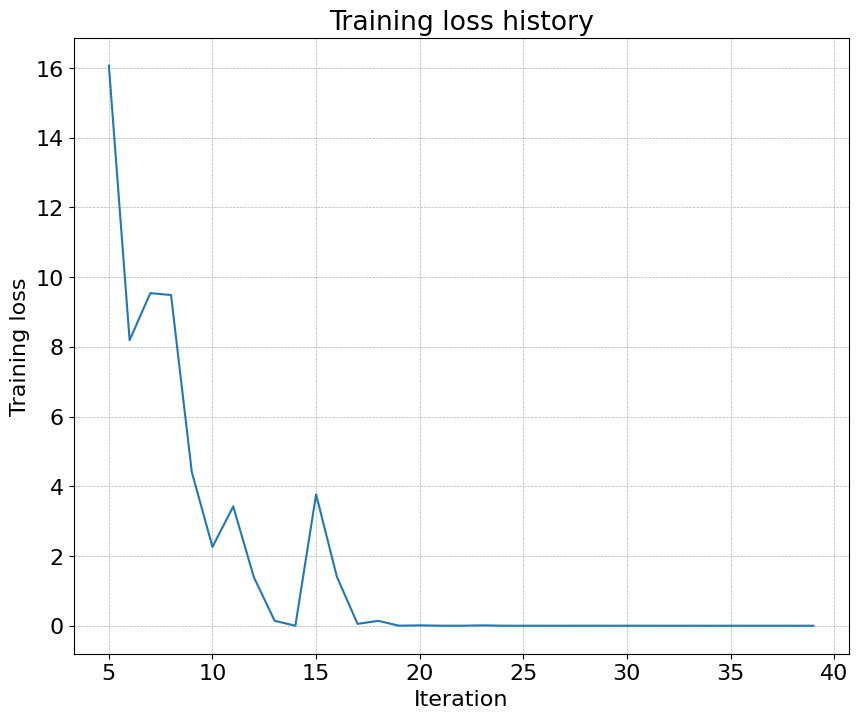

In [18]:
num_train = 50
small_data = {
  "X_train": data["X_train"][:num_train],
  "y_train": data["y_train"][:num_train],
  "X_val": data["X_val"],
  "y_val": data["y_val"],
}


# Your task #9
# *****START OF YOUR CODE (DO NOT DELETE/MODIFY THIS LINE)*****
# Hyperparameters for overfitting
hidden_dims = [50, 50]  # Two hidden layers with 50 units each
input_dim = 3 * 32 * 32 + 1  # Input dimension for CIFAR-10 (flattened image size)
num_classes = 10         # Number of classes
weight_scale = 1e-1      # Larger weight scale for faster learning
learning_rate = 1e-3     # Larger learning rate to encourage overfitting
reg = 0.0                # Set regularization to zero to avoid penalizing weights

# Initialize the model
model = FullyConnectedNet(
    hidden_dims=hidden_dims,
    input_dim=input_dim,
    num_classes=num_classes,
    reg=reg,
    weight_scale=weight_scale,
    dtype=torch.float32
)

# *****END OF YOUR CODE (DO NOT DELETE/MODIFY THIS LINE)*****


solver = Solver(
    model,
    small_data,
    update_rule=sgd,
    print_every=10,
    num_epochs=20,
    batch_size=25,
    optim_config={"learning_rate": learning_rate},
)
solver.train()

plt.plot(solver.loss_history)
plt.title("Training loss history")
plt.xlabel("Iteration")
plt.ylabel("Training loss")
plt.grid(linestyle='--', linewidth=0.5)
plt.show()

- Now, try to use a five-layer network with 50 units on each layer to overfit on 50 training examples.
- **Your task #10**: Again, you will have to adjust the learning rate and weight initialization scale, but you should be able to achieve 100% training accuracy within 20 epochs.

(Iteration 1 / 40) loss: inf
(Epoch 0 / 20) train acc: 0.140000; val_acc: 0.110000
(Epoch 1 / 20) train acc: 0.200000; val_acc: 0.078000
(Epoch 2 / 20) train acc: 0.320000; val_acc: 0.092000
(Epoch 3 / 20) train acc: 0.400000; val_acc: 0.076000
(Epoch 4 / 20) train acc: 0.540000; val_acc: 0.108000
(Epoch 5 / 20) train acc: 0.620000; val_acc: 0.105000
(Iteration 11 / 40) loss: 7.039219
(Epoch 6 / 20) train acc: 0.800000; val_acc: 0.091000
(Epoch 7 / 20) train acc: 0.920000; val_acc: 0.094000
(Epoch 8 / 20) train acc: 0.920000; val_acc: 0.093000
(Epoch 9 / 20) train acc: 0.820000; val_acc: 0.106000
(Epoch 10 / 20) train acc: 0.980000; val_acc: 0.102000
(Iteration 21 / 40) loss: 0.001326
(Epoch 11 / 20) train acc: 0.980000; val_acc: 0.099000
(Epoch 12 / 20) train acc: 0.980000; val_acc: 0.100000
(Epoch 13 / 20) train acc: 1.000000; val_acc: 0.101000
(Epoch 14 / 20) train acc: 1.000000; val_acc: 0.102000
(Epoch 15 / 20) train acc: 1.000000; val_acc: 0.098000
(Iteration 31 / 40) loss: 0.001

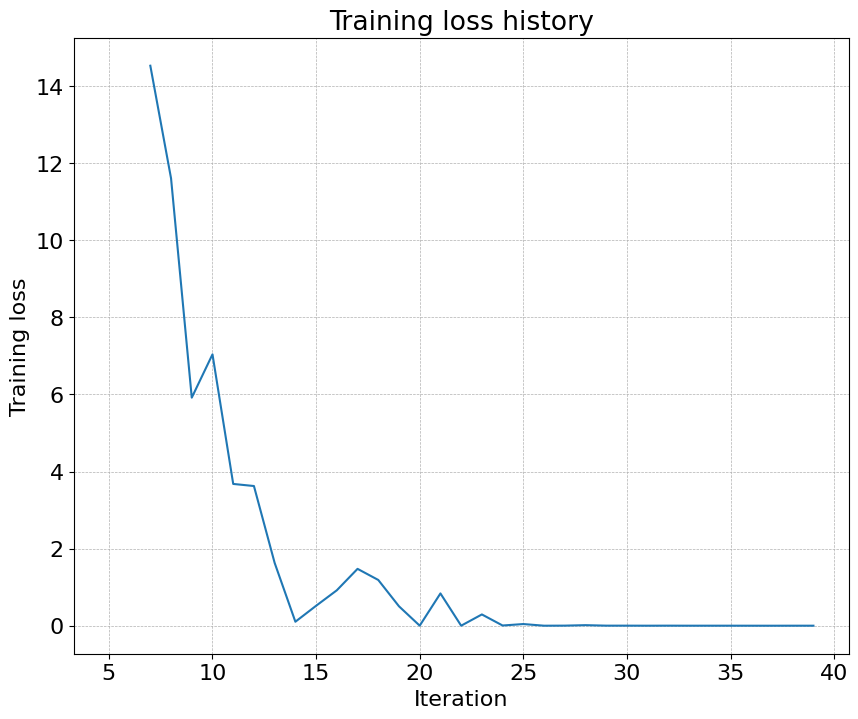

In [19]:
num_train = 50
small_data = {
  'X_train': data['X_train'][:num_train],
  'y_train': data['y_train'][:num_train],
  'X_val': data['X_val'],
  'y_val': data['y_val'],
}

# Your task #10
# *****START OF YOUR CODE (DO NOT DELETE/MODIFY THIS LINE)*****
# Hyperparameters for overfitting
hidden_dims = [50, 50, 50, 50]  # Two hidden layers with 50 units each
input_dim = 3 * 32 * 32 + 1  # Input dimension for CIFAR-10 (flattened image size)
num_classes = 10         # Number of classes
weight_scale = 1e-1 * 1.5      # Larger weight scale for faster learning
learning_rate = 1e-3     # Larger learning rate to encourage overfitting
reg = 0.0                # Set regularization to zero to avoid penalizing weights

# Initialize the model
model = FullyConnectedNet(
    hidden_dims=hidden_dims,
    input_dim=input_dim,
    num_classes=num_classes,
    reg=reg,
    weight_scale=weight_scale,
)
# *****END OF YOUR CODE (DO NOT DELETE/MODIFY THIS LINE)*****

solver = Solver(
    model,
    small_data,
    print_every=10,
    num_epochs=20,
    batch_size=25,
    update_rule=sgd,
    optim_config={'learning_rate': learning_rate},
)
solver.train()

plt.plot(solver.loss_history)
plt.title('Training loss history')
plt.xlabel('Iteration')
plt.ylabel('Training loss')
plt.grid(linestyle='--', linewidth=0.5)
plt.show()

# Part #2: Optimization
- So far we have used vanilla **stochastic gradient descent (SGD)** as our update rule. More sophisticated update rules can make it easier to train deep networks. We will implement a few of the most commonly used update rules and compare them to vanilla SGD.

## SGD + Momentum
- Stochastic gradient descent with **momentum** is a widely used update rule that tends to make deep networks converge faster than vanilla stochastic gradient descent. See the Momentum section at lecture slides about chapter 8 for more information.

- **Your task #11**: Implement the SGD+momentum update rule below and run the following to check your implementation. You should see errors less than e-8.

In [20]:
def sgd_momentum(w, dw, config=None):
    """
    Performs stochastic gradient descent with momentum.

    config format:
    - learning_rate: Scalar learning rate.
    - momentum: Scalar between 0 and 1 giving the momentum value.
      Setting momentum = 0 reduces to sgd.
    - velocity: A numpy array of the same shape as w and dw used to store a
      moving average of the gradients.
    """
    if config is None:
        config = {}
    config.setdefault("learning_rate", 1e-2)
    config.setdefault("momentum", 0.9)
    v = config.get("velocity", torch.zeros_like(w))

    next_w = None
    # Your task #11
    # *****START OF YOUR CODE (DO NOT DELETE/MODIFY THIS LINE)*****
    # Perform the momentum update
    mu = config["momentum"]
    lr = config["learning_rate"]

    # Update the velocity
    v = mu * v - lr * dw

    # Update the weights
    next_w = w + v

    # *****END OF YOUR CODE (DO NOT DELETE/MODIFY THIS LINE)*****
    config["velocity"] = v

    return next_w, config

In [21]:
N, D = 4, 5
w = torch.linspace(-0.4, 0.6, steps=N*D).view(N, D)
dw = torch.linspace(-0.6, 0.4, steps=N*D).view(N, D)
v = torch.linspace(0.6, 0.9, steps=N*D).view(N, D)

config = {"learning_rate": 1e-3, "velocity": v}
next_w, _ = sgd_momentum(w, dw, config=config)

expected_next_w = torch.Tensor([
  [ 0.1406,      0.20738947,  0.27417895,  0.34096842,  0.40775789],
  [ 0.47454737,  0.54133684,  0.60812632,  0.67491579,  0.74170526],
  [ 0.80849474,  0.87528421,  0.94207368,  1.00886316,  1.07565263],
  [ 1.14244211,  1.20923158,  1.27602105,  1.34281053,  1.4096    ]])
expected_velocity = torch.Tensor([
  [ 0.5406,      0.55475789,  0.56891579, 0.58307368,  0.59723158],
  [ 0.61138947,  0.62554737,  0.63970526,  0.65386316,  0.66802105],
  [ 0.68217895,  0.69633684,  0.71049474,  0.72465263,  0.73881053],
  [ 0.75296842,  0.76712632,  0.78128421,  0.79544211,  0.8096    ]])

# Should see relative errors around e-8 or less
print("next_w error: ", rel_error(next_w, expected_next_w))
print("velocity error: ", rel_error(expected_velocity, config["velocity"]))

next_w error:  tensor(1.4370e-07)
velocity error:  tensor(5.3721e-08)


- Once you have done so, run the following to train a 6-layer network with both SGD and SGD+momentum. You can see the SGD+momentum update rule converge faster.

Running with   sgd 
(Iteration 1 / 200) loss: 2.631745
(Epoch 0 / 5) train acc: 0.113000; val_acc: 0.106000
(Iteration 11 / 200) loss: 2.331782
(Iteration 21 / 200) loss: 2.272914
(Iteration 31 / 200) loss: 2.086000
(Epoch 1 / 5) train acc: 0.243000; val_acc: 0.206000
(Iteration 41 / 200) loss: 2.100133
(Iteration 51 / 200) loss: 2.080088
(Iteration 61 / 200) loss: 2.050643
(Iteration 71 / 200) loss: 1.954586
(Epoch 2 / 5) train acc: 0.287000; val_acc: 0.253000
(Iteration 81 / 200) loss: 1.964198
(Iteration 91 / 200) loss: 1.892048
(Iteration 101 / 200) loss: 1.934118
(Iteration 111 / 200) loss: 1.973531
(Epoch 3 / 5) train acc: 0.308000; val_acc: 0.287000
(Iteration 121 / 200) loss: 1.846781
(Iteration 131 / 200) loss: 1.730105
(Iteration 141 / 200) loss: 1.918837
(Iteration 151 / 200) loss: 1.928568
(Epoch 4 / 5) train acc: 0.351000; val_acc: 0.297000
(Iteration 161 / 200) loss: 1.588051
(Iteration 171 / 200) loss: 1.774450
(Iteration 181 / 200) loss: 2.041377
(Iteration 191 / 200) l

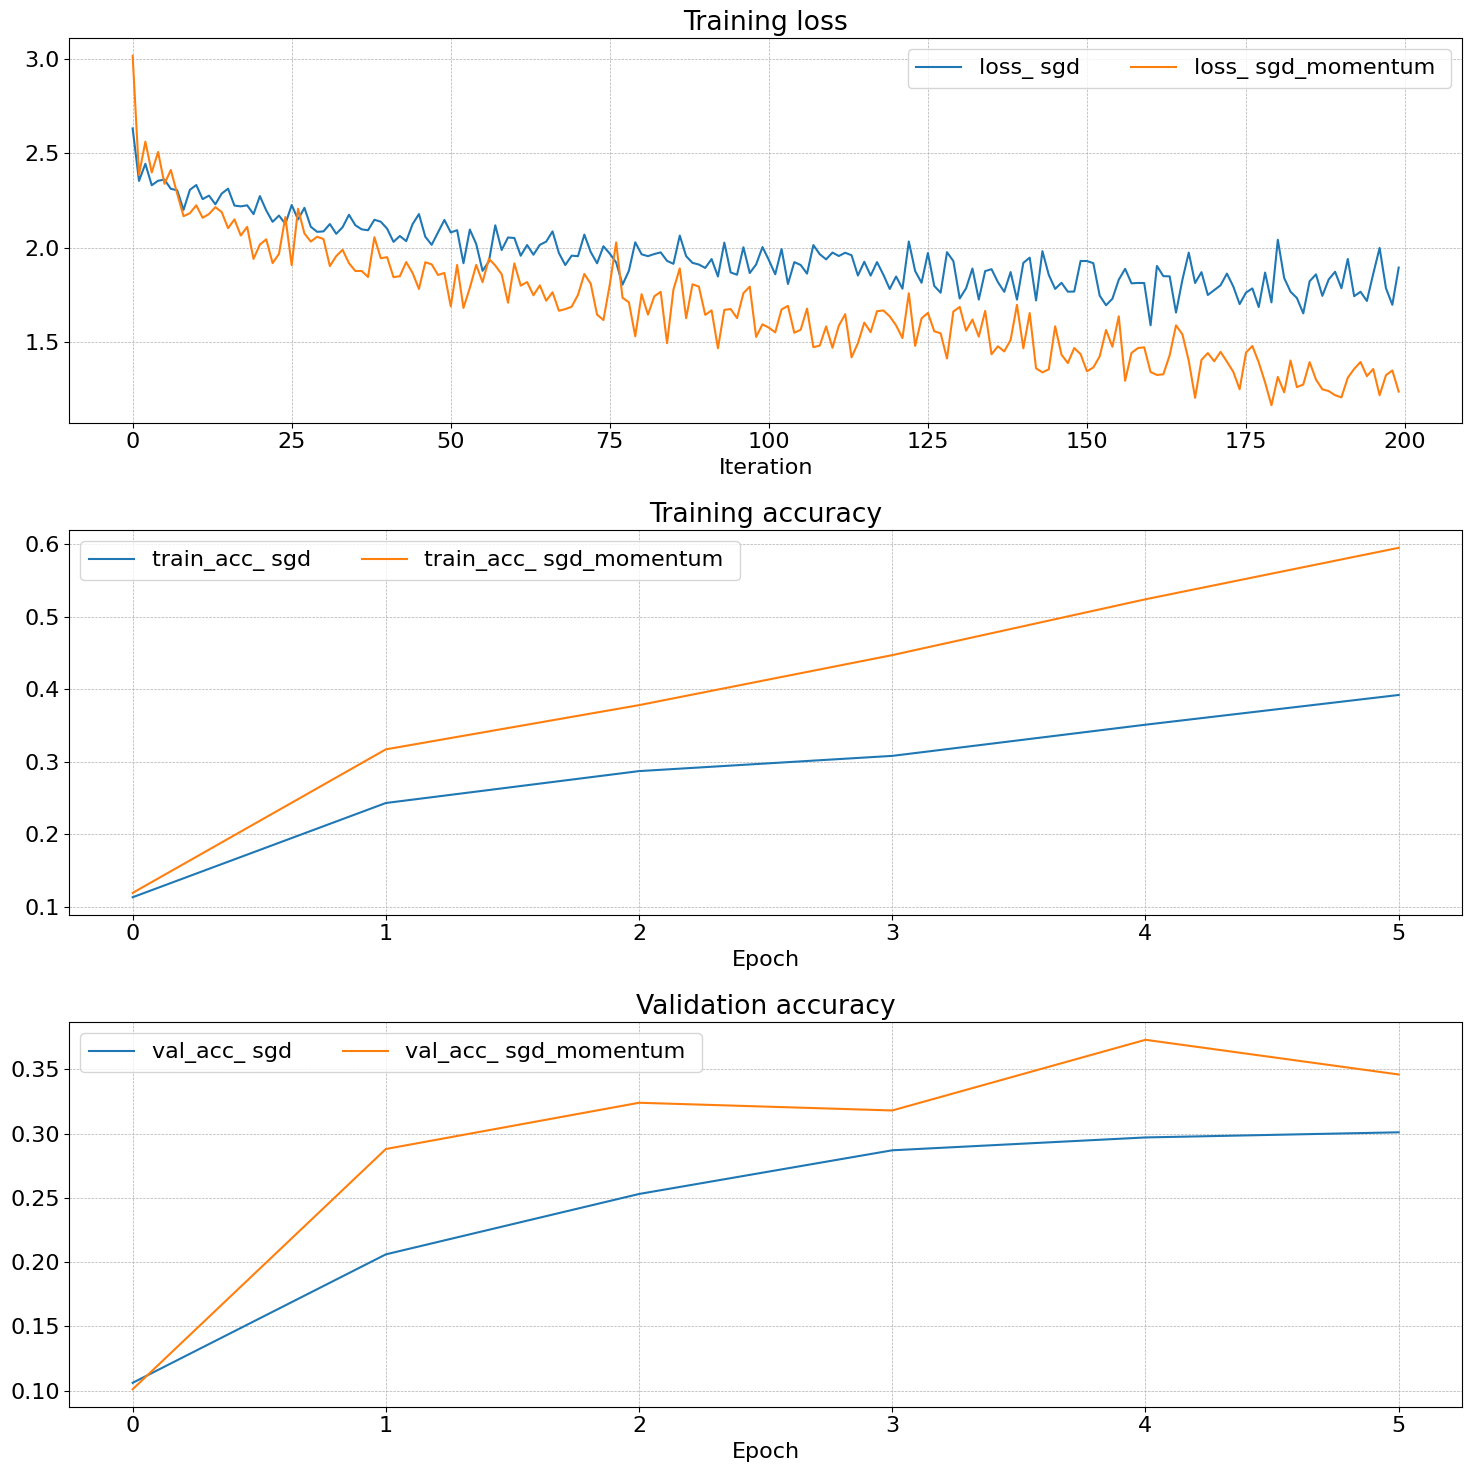

In [22]:
num_train = 4000
small_data = {
  'X_train': data['X_train'][:num_train],
  'y_train': data['y_train'][:num_train],
  'X_val': data['X_val'],
  'y_val': data['y_val'],
}

solvers = {}

for update_rule in [sgd, sgd_momentum]:
    print('Running with ', str(update_rule)[9:-18])
    model = FullyConnectedNet(
        [100, 100, 100, 100, 100],
        weight_scale=5e-2
    )

    solver = Solver(
        model,
        small_data,
        update_rule=update_rule,
        num_epochs=5,
        batch_size=100,
        optim_config={'learning_rate': 5e-3},
        verbose=True,
    )
    solvers[update_rule] = solver
    solver.train()

fig, axes = plt.subplots(3, 1, figsize=(15, 15))

axes[0].set_title('Training loss')
axes[0].set_xlabel('Iteration')
axes[1].set_title('Training accuracy')
axes[1].set_xlabel('Epoch')
axes[2].set_title('Validation accuracy')
axes[2].set_xlabel('Epoch')

for update_rule, solver in solvers.items():
    axes[0].plot(solver.loss_history, label=f"loss_{str(update_rule)[9:-18]}")
    axes[1].plot(solver.train_acc_history, label=f"train_acc_{str(update_rule)[9:-18]}")
    axes[2].plot(solver.val_acc_history, label=f"val_acc_{str(update_rule)[9:-18]}")
    
for ax in axes:
    ax.legend(loc="best", ncol=4)
    ax.grid(linestyle='--', linewidth=0.5)

plt.tight_layout()
plt.show()

## Adaptive Learning Methods: RMSPropr and Adam
- **RMSProp** and **Adam** are update rules that set per-parameter learning rates by using a running average of the second moments of gradients.
- **Your task #12**: implement the RMSProp update rule and check your implementations using the tests below.

In [23]:
def rmsprop(w, dw, config=None):
    """
    Uses the RMSProp update rule, which uses a moving average of squared
    gradient values to set adaptive per-parameter learning rates.

    config format:
    - learning_rate: Scalar learning rate.
    - decay_rate: Scalar between 0 and 1 giving the decay rate for the squared
      gradient cache.
    - epsilon: Small scalar used for smoothing to avoid dividing by zero.
    - cache: Moving average of second moments of gradients.
    """
    if config is None:
        config = {}
    config.setdefault("learning_rate", 1e-2)
    config.setdefault("decay_rate", 0.99)
    config.setdefault("epsilon", 1e-8)
    config.setdefault("cache", torch.zeros_like(w))

    next_w = None
    # Your task #12
    # *****START OF YOUR CODE (DO NOT DELETE/MODIFY THIS LINE)*****
    # Retrieve the parameters from config
    decay_rate = config["decay_rate"]
    lr = config["learning_rate"]
    epsilon = config["epsilon"]
    cache = config["cache"]

    # Update the cache with the squared gradient values
    cache = decay_rate * cache + (1 - decay_rate) * dw**2

    # Compute the updated weights using RMSProp rule
    next_w = w - lr * dw / (torch.sqrt(cache) + epsilon)

    # Save the updated cache back to config
    config["cache"] = cache
    
    # *****END OF YOUR CODE (DO NOT DELETE/MODIFY THIS LINE)*****

    return next_w, config

- Test RMSProp implementation

In [24]:
N, D = 4, 5
w = torch.linspace(-0.4, 0.6, steps=N*D).view(N, D)
dw = torch.linspace(-0.6, 0.4, steps=N*D).view(N, D)
cache = torch.linspace(0.6, 0.9, steps=N*D).view(N, D)

config = {'learning_rate': 1e-2, 'cache': cache}
next_w, _ = rmsprop(w, dw, config=config)

expected_next_w = torch.Tensor([
  [-0.39223849, -0.34037513, -0.28849239, -0.23659121, -0.18467247],
  [-0.132737,   -0.08078555, -0.02881884,  0.02316247,  0.07515774],
  [ 0.12716641,  0.17918792,  0.23122175,  0.28326742,  0.33532447],
  [ 0.38739248,  0.43947102,  0.49155973,  0.54365823,  0.59576619]])
expected_cache = torch.Tensor([
  [ 0.5976,      0.6126277,   0.6277108,   0.64284931,  0.65804321],
  [ 0.67329252,  0.68859723,  0.70395734,  0.71937285,  0.73484377],
  [ 0.75037008,  0.7659518,   0.78158892,  0.79728144,  0.81302936],
  [ 0.82883269,  0.84469141,  0.86060554,  0.87657507,  0.8926    ]])

# You should see relative errors around e-7 or less
print('next_w error: ', rel_error(expected_next_w, next_w))
print('cache error: ', rel_error(expected_cache, config['cache']))

next_w error:  tensor(1.6083e-07)
cache error:  tensor(4.9870e-08)


- **Your task #13**: implement the Adam update rule and check your implementations using the tests below. Storing the next value of w in the next_w variable. Don't forget to update the m, v, and t variables stored in config. NOTE: In order to match the reference output, please modify t before using it in any calculations.  

In [25]:
def adam(w, dw, config=None):
    """
    Uses the Adam update rule, which incorporates moving averages of both the
    gradient and its square and a bias correction term.

    config format:
    - learning_rate: Scalar learning rate.
    - beta1: Decay rate for moving average of first moment of gradient.
    - beta2: Decay rate for moving average of second moment of gradient.
    - epsilon: Small scalar used for smoothing to avoid dividing by zero.
    - m: Moving average of gradient.
    - v: Moving average of squared gradient.
    - t: Iteration number.
    """
    if config is None:
        config = {}
    config.setdefault("learning_rate", 1e-3)
    config.setdefault("beta1", 0.9)
    config.setdefault("beta2", 0.999)
    config.setdefault("epsilon", 1e-8)
    config.setdefault("m", torch.zeros_like(w))
    config.setdefault("v", torch.zeros_like(w))
    config.setdefault("t", 0)

    next_w = None 

    # Your task #13
    # *****START OF YOUR CODE (DO NOT DELETE/MODIFY THIS LINE)*****
    # Retrieve the parameters from config
    learning_rate = config["learning_rate"]
    beta1 = config["beta1"]
    beta2 = config["beta2"]
    epsilon = config["epsilon"]
    m = config["m"]
    v = config["v"]
    t = config["t"] + 1  # Increment time step for bias correction

    # Update moving averages for m and v
    m = beta1 * m + (1 - beta1) * dw  # First moment estimate (gradient)
    v = beta2 * v + (1 - beta2) * (dw**2)  # Second moment estimate (squared gradient)

    # Bias correction to compensate for the initialization of m and v
    m_hat = m / (1 - beta1**t)
    v_hat = v / (1 - beta2**t)

    # Compute the parameter update
    next_w = w - learning_rate * m_hat / (torch.sqrt(v_hat) + epsilon)

    # Save updated values back into config
    config["m"] = m
    config["v"] = v
    config["t"] = t

    # *****END OF YOUR CODE (DO NOT DELETE/MODIFY THIS LINE)*****

    return next_w, config

- Test Adam implementation

In [26]:
N, D = 4, 5
w = torch.linspace(-0.4, 0.6, steps=N*D).view(N, D)
dw = torch.linspace(-0.6, 0.4, steps=N*D).view(N, D)
m = torch.linspace(0.6, 0.9, steps=N*D).view(N, D)
v = torch.linspace(0.7, 0.5, steps=N*D).view(N, D)

config = {'learning_rate': 1e-2, 'm': m, 'v': v, 't': 5}
next_w, _ = adam(w, dw, config=config)

expected_next_w = torch.Tensor([
  [-0.40094747, -0.34836187, -0.29577703, -0.24319299, -0.19060977],
  [-0.1380274,  -0.08544591, -0.03286534,  0.01971428,  0.0722929],
  [ 0.1248705,   0.17744702,  0.23002243,  0.28259667,  0.33516969],
  [ 0.38774145,  0.44031188,  0.49288093,  0.54544852,  0.59801459]])
expected_v = torch.Tensor([
  [ 0.69966,     0.68908382,  0.67851319,  0.66794809,  0.65738853,],
  [ 0.64683452,  0.63628604,  0.6257431,   0.61520571,  0.60467385,],
  [ 0.59414753,  0.58362676,  0.57311152,  0.56260183,  0.55209767,],
  [ 0.54159906,  0.53110598,  0.52061845,  0.51013645,  0.49966,   ]])
expected_m = torch.Tensor([
  [ 0.48,        0.49947368,  0.51894737,  0.53842105,  0.55789474],
  [ 0.57736842,  0.59684211,  0.61631579,  0.63578947,  0.65526316],
  [ 0.67473684,  0.69421053,  0.71368421,  0.73315789,  0.75263158],
  [ 0.77210526,  0.79157895,  0.81105263,  0.83052632,  0.85      ]])

# You should see relative errors around e-7 or less
print('next_w error: ', rel_error(expected_next_w, next_w))
print('v error: ', rel_error(expected_v, config['v']))
print('m error: ', rel_error(expected_m, config['m']))

next_w error:  tensor(1.4172e-07)
v error:  tensor(5.2972e-08)
m error:  tensor(5.9667e-08)


- Once you have debugged your RMSProp and Adam implementations, run the following to train a pair of deep networks using these new update rules:

Running with   adam 
(Iteration 1 / 200) loss: 3.008472
(Epoch 0 / 5) train acc: 0.100000; val_acc: 0.106000
(Iteration 11 / 200) loss: 2.055124
(Iteration 21 / 200) loss: 1.943974
(Iteration 31 / 200) loss: 1.889178
(Epoch 1 / 5) train acc: 0.349000; val_acc: 0.306000
(Iteration 41 / 200) loss: 1.790107
(Iteration 51 / 200) loss: 1.610836
(Iteration 61 / 200) loss: 1.819677
(Iteration 71 / 200) loss: 1.772639
(Epoch 2 / 5) train acc: 0.413000; val_acc: 0.365000
(Iteration 81 / 200) loss: 1.700335
(Iteration 91 / 200) loss: 1.558708
(Iteration 101 / 200) loss: 1.635542
(Iteration 111 / 200) loss: 1.438994
(Epoch 3 / 5) train acc: 0.495000; val_acc: 0.371000
(Iteration 121 / 200) loss: 1.344564
(Iteration 131 / 200) loss: 1.511823
(Iteration 141 / 200) loss: 1.364540
(Iteration 151 / 200) loss: 1.165004
(Epoch 4 / 5) train acc: 0.509000; val_acc: 0.371000
(Iteration 161 / 200) loss: 1.302011
(Iteration 171 / 200) loss: 1.456997
(Iteration 181 / 200) loss: 1.183882
(Iteration 191 / 200) 

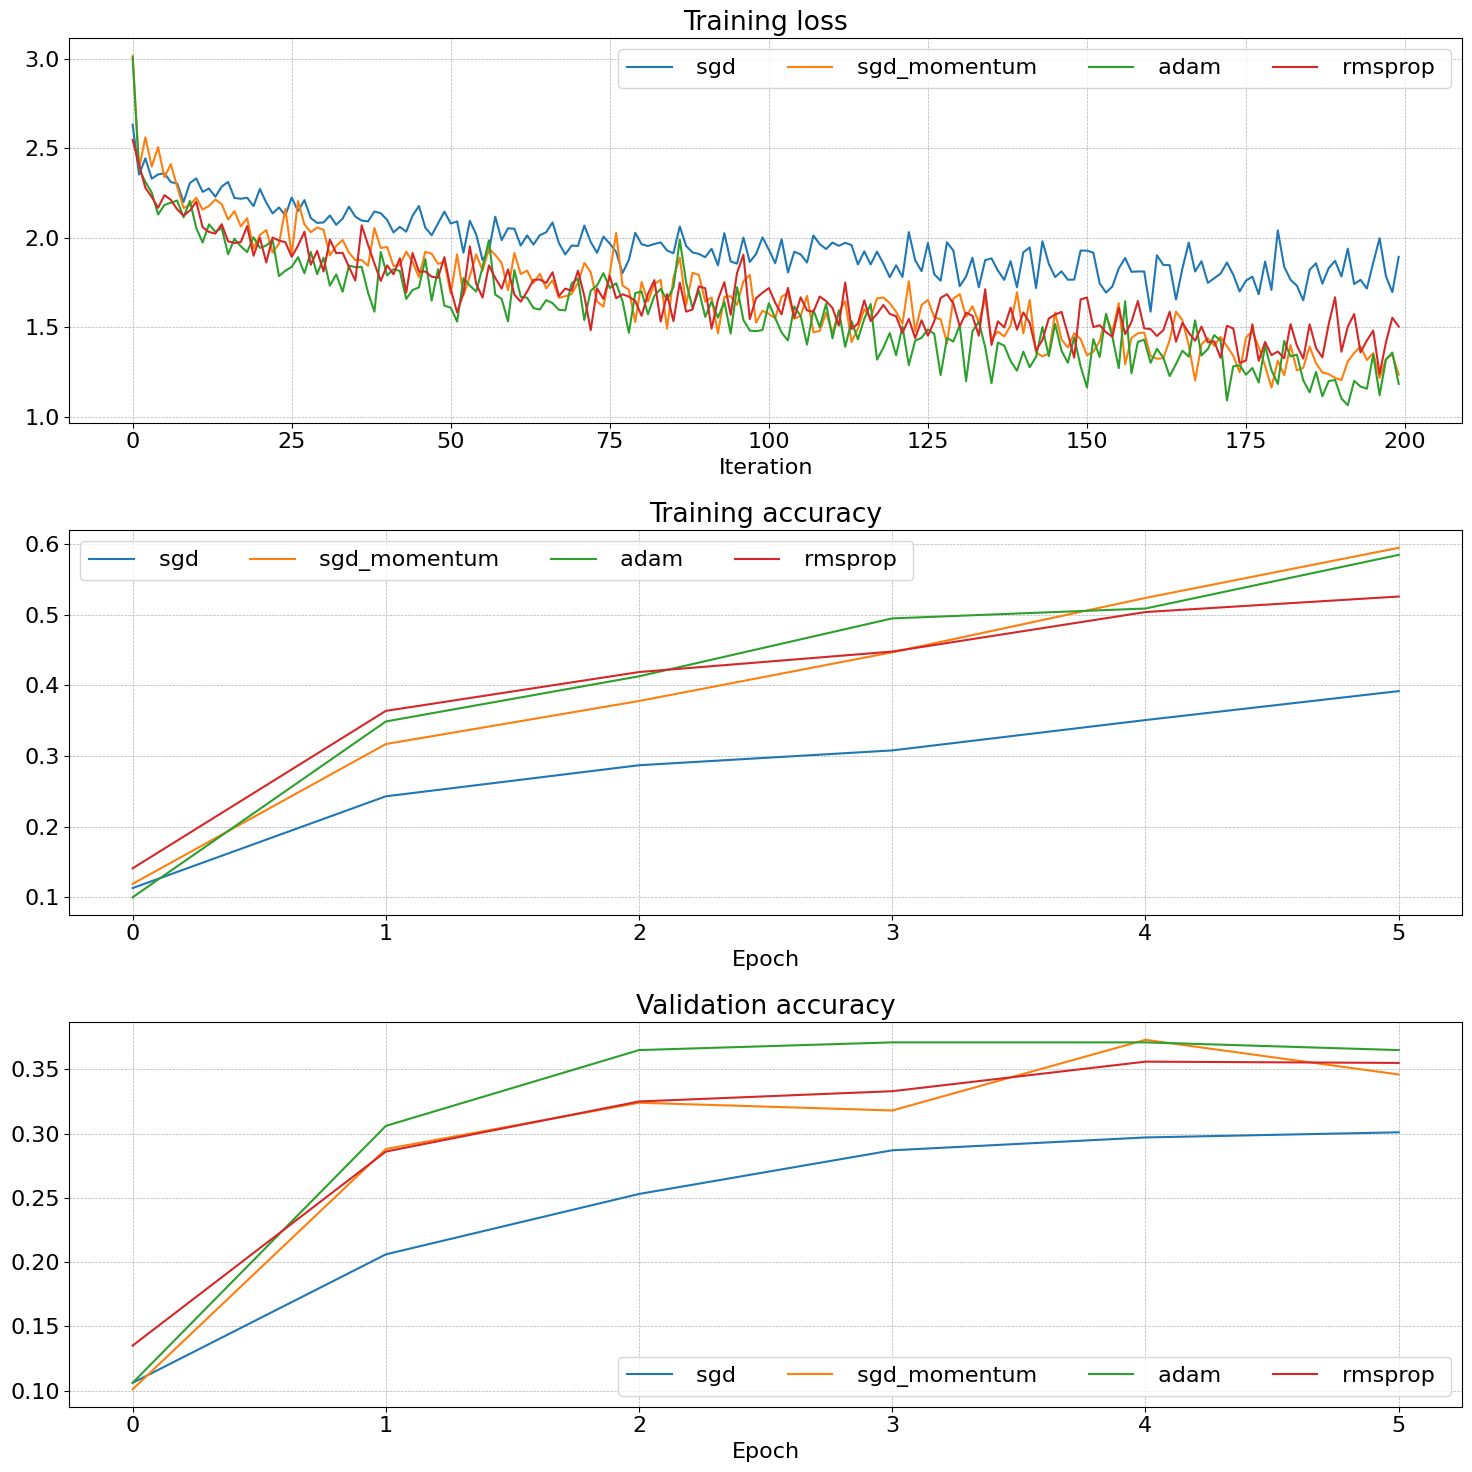

In [27]:
learning_rates = {str(rmsprop): 1e-4, str(adam): 1e-3}
for update_rule in [adam, rmsprop]:
    print('Running with ', str(update_rule)[9:-18])
    model = FullyConnectedNet(
        [100, 100, 100, 100, 100],
        weight_scale=5e-2
    )
    solver = Solver(
        model,
        small_data,
        update_rule=update_rule,
        num_epochs=5,
        batch_size=100,
        optim_config={'learning_rate': learning_rates[str(update_rule)]},
        verbose=True
    )
    solvers[update_rule] = solver
    solver.train()
    print()
    
fig, axes = plt.subplots(3, 1, figsize=(15, 15))

axes[0].set_title('Training loss')
axes[0].set_xlabel('Iteration')
axes[1].set_title('Training accuracy')
axes[1].set_xlabel('Epoch')
axes[2].set_title('Validation accuracy')
axes[2].set_xlabel('Epoch')

for update_rule, solver in solvers.items():
    axes[0].plot(solver.loss_history, label=f"{str(update_rule)[9:-18]}")
    axes[1].plot(solver.train_acc_history, label=f"{str(update_rule)[9:-18]}")
    axes[2].plot(solver.val_acc_history, label=f"{str(update_rule)[9:-18]}")
    
for ax in axes:
    ax.legend(loc='best', ncol=4)
    ax.grid(linestyle='--', linewidth=0.5)

plt.tight_layout()
plt.show()

# Part #3: Regularization

## Dropout
- **Your task #14**: implement the forward pass for dropout. Since dropout behaves differently during training and testing, make sure to implement the operation for both modes. Once you have done so, run the cell below to test your implementation.

In [28]:
def dropout_forward(x, dropout_param):
    """Forward pass for inverted dropout.

    Note that this is different from the vanilla version of dropout.
    Here, p is the probability of keeping a neuron output, as opposed to
    the probability of dropping a neuron output.
    See http://cs231n.github.io/neural-networks-2/#reg for more details.

    Inputs:
    - x: Input data, of any shape
    - dropout_param: A dictionary with the following keys:
      - p: Dropout parameter. We keep each neuron output with probability p.
      - mode: 'test' or 'train'. If the mode is train, then perform dropout;
        if the mode is test, then just return the input.
      - seed: Seed for the random number generator. Passing seed makes this
        function deterministic, which is needed for gradient checking but not
        in real networks.

    Outputs:
    - out: Array of the same shape as x.
    - cache: tuple (dropout_param, mask). In training mode, mask is the dropout
      mask that was used to multiply the input; in test mode, mask is None.
    """
    p, mode = dropout_param["p"], dropout_param["mode"]
    if "seed" in dropout_param:
        np.random.seed(dropout_param["seed"])

    mask = None
    out = None

    # Your task #14
    # *****START OF YOUR CODE (DO NOT DELETE/MODIFY THIS LINE)*****
    # Training mode: Perform dropout
    if mode == "train":
        # Generate random mask with the same shape as x
        mask = (np.random.rand(*x.shape) < p) / p  # Scale up by 1/p to maintain expected value
        out = x * mask  # Apply the mask to the input

    # Test mode: No dropout, just return the input
    elif mode == "test":
        out = x

    # *****END OF YOUR CODE (DO NOT DELETE/MODIFY THIS LINE)*****

    cache = (dropout_param, mask)
    out = out.to(dtype=x.dtype)

    return out, cache

In [29]:
np.random.seed(3201)
x = torch.randn(500, 500) + 10

for p in [0.25, 0.4, 0.7]:
    out, _ = dropout_forward(x, {'mode': 'train', 'p': p})
    out_test, _ = dropout_forward(x, {'mode': 'test', 'p': p})

    print('Running tests with p = ', p)
    print('Mean of input: ', x.mean())
    print('Mean of train-time output: ', out.mean())
    print('Mean of test-time output: ', out_test.mean())
    print('Fraction of train-time output set to zero: ', (out == 0).float().mean())
    print('Fraction of test-time output set to zero: ', (out_test == 0).float().mean())
    print()

Running tests with p =  0.25
Mean of input:  tensor(10.0015)
Mean of train-time output:  tensor(10.0503)
Mean of test-time output:  tensor(10.0015)
Fraction of train-time output set to zero:  tensor(0.7488)
Fraction of test-time output set to zero:  tensor(0.)

Running tests with p =  0.4
Mean of input:  tensor(10.0015)
Mean of train-time output:  tensor(10.0008)
Mean of test-time output:  tensor(10.0015)
Fraction of train-time output set to zero:  tensor(0.6001)
Fraction of test-time output set to zero:  tensor(0.)

Running tests with p =  0.7
Mean of input:  tensor(10.0015)
Mean of train-time output:  tensor(9.9949)
Mean of test-time output:  tensor(10.0015)
Fraction of train-time output set to zero:  tensor(0.3004)
Fraction of test-time output set to zero:  tensor(0.)



- **Your task #15**: implement the backward pass for dropout. Since dropout behaves differently during training and testing, make sure to implement the operation for both modes. Once you have done so, run the cell below to test your implementation.

In [30]:
def dropout_backward(dout, cache):
    """Backward pass for inverted dropout.

    Inputs:
    - dout: Upstream derivatives, of any shape
    - cache: (dropout_param, mask) from dropout_forward.
    """
    dropout_param, mask = cache
    mode = dropout_param["mode"]

    dx = None
    if mode == "train":

        # Your task #15
        # *****START OF YOUR CODE (DO NOT DELETE/MODIFY THIS LINE)*****
        dx = dout * mask
        # *****END OF YOUR CODE (DO NOT DELETE/MODIFY THIS LINE)*****
    elif mode == "test":
        dx = dout
    return dx

### Incorporating Dropout to DNN
- **Your task #16**: modify `generic_forward` to use dropout. Specifically, if `dropout_param` is not None, then `dropout_forward` should be conducted

In [31]:
def generic_forward(x, w, b, dropout_param=None, last=False):
    """Convenience layer composed of linear layer, ReLU activation, and DropOut

    Inputs:
    - x: Input to the affine layer
    - w, b: Weights for the affine layer
    - dropout_param: Dictionary of required Dropout parameters
    - last: Indicates wether to perform just affine forward

    Returns a tuple of:
    - out: Output from the ReLU or Dropout
    - cache: Object to give to the backward pass
    """
    # Initialize optional caches to None
    relu_cache, dropout_cache = None, None

    # Linear forward is a must
    out, fc_cache = linear_forward(x, w, b)

    # If the the layer is not last
    if not last:
        # Pass the outputs through activation
        out, relu_cache = relu_forward(out) # perform relu

        # Your task #16
        # *****START OF YOUR CODE (DO NOT DELETE/MODIFY THIS LINE)*****
        # If dropout_param is provided, apply dropout
        if dropout_param is not None:
            out, dropout_cache = dropout_forward(out, dropout_param)

        # *****END OF YOUR CODE (DO NOT DELETE/MODIFY THIS LINE)*****
        
    # Prepare cache for backward pass
    cache = fc_cache, relu_cache, dropout_cache

    return out, cache

- **Your task #17**: modify `generic_backward` to use dropout. Specifically, if `dropout_cache` is not None, then `dropout_backward` should be conducted

In [32]:
def generic_backward(dout, cache):
    """Backward pass for the linear-relu-dropout convenience layer.
    """

    # Get the prapared caches from the forward pass
    fc_cache, relu_cache, dropout_cache = cache

    # Your task #17
    # *****START OF YOUR CODE (DO NOT DELETE/MODIFY THIS LINE)*****
    # If dropout was performed, backpropagate through dropout
    if dropout_cache is not None:
        dout = dropout_backward(dout, dropout_cache)

    # *****END OF YOUR CODE (DO NOT DELETE/MODIFY THIS LINE)*****
    
    # If relu was performed
    if relu_cache is not None:
        dout = relu_backward(dout, relu_cache)

    # Linear backward is a must
    dx, dw, db = linear_backward(dout, fc_cache)

    return dx, dw, db

- **Your task #18 (forward)**: modify your implementation of forward (task # 7) to use dropout. Specifically, if the constructor of the network receives a value that is not 1 for the `dropout_keep_ratio` parameter, then the net should add a dropout layer immediately after every ReLU nonlinearity. After doing so, run the following to numerically gradient-check your implementation.

In [33]:
class FullyConnectedNet(object):
    """Class for a multi-layer fully connected neural network.

    Network contains an arbitrary number of hidden layers, ReLU nonlinearities,
    and a softmax loss function. This will also implement dropout as option. 
    For a network with L layers, the architecture will be

    {Linear - relu - [dropout]} x (L - 1) - Linear - softmax

    Learnable parameters are stored in the self.params dictionary and will be learned
    using the Solver class.
    """

    def __init__(
        self,
        hidden_dims,
        input_dim=3 * 32 * 32 + 1,
        num_classes=10,
        dropout_keep_ratio=1,
        reg=0.0,
        weight_scale=1e-2,
        dtype=np.float32,
        seed=None,
    ):
        """Initialize a new FullyConnectedNet.

        Inputs:
        - hidden_dims: A list of integers giving the size of each hidden layer.
        - input_dim: An integer giving the size of the input.
        - num_classes: An integer giving the number of classes to classify.
        - dropout_keep_ratio: Scalar between 0 and 1 giving dropout strength.
            If dropout_keep_ratio=1 then the network should not use dropout at all.
        - reg: Scalar giving L2 regularization strength.
        - weight_scale: Scalar giving the standard deviation for random
            initialization of the weights.
        - dtype: A numpy datatype object; all computations will be performed using
            this datatype. float32 is faster but less accurate, so you should use
            float64 for numeric gradient checking.
        - seed: If not None, then pass this random seed to the dropout layers.
            This will make the dropout layers deteriminstic so we can gradient check the model.
        """
        self.use_dropout = dropout_keep_ratio != 1
        self.reg = reg
        self.num_layers = 1 + len(hidden_dims)
        self.dtype = dtype
        self.params = {}

        # Please copy from your task #6
        # *****START OF YOUR CODE (DO NOT DELETE/MODIFY THIS LINE)*****
        # Initialize weights and biases
        layer_input_dim = input_dim
        for i, hidden_dim in enumerate(hidden_dims):
            self.params[f'W{i+1}'] = weight_scale * torch.randn(layer_input_dim, hidden_dim)
            self.params[f'b{i+1}'] = torch.zeros(hidden_dim)
            layer_input_dim = hidden_dim
        # Output layer
        self.params[f'W{self.num_layers}'] = weight_scale * torch.randn(layer_input_dim, num_classes)
        self.params[f'b{self.num_layers}'] = torch.zeros(num_classes)

        # *****END OF YOUR CODE (DO NOT DELETE/MODIFY THIS LINE)*****

        # When using dropout we need to pass a dropout_param dictionary to each
        # dropout layer so that the layer knows the dropout probability and the mode
        # (train / test). You can pass the same dropout_param to each dropout layer.
        self.dropout_param = {}
        if self.use_dropout:
            self.dropout_param = {"mode": "train", "p": dropout_keep_ratio}
            if seed is not None:
                self.dropout_param["seed"] = seed

    def loss(self, X, y=None):
        """Compute loss and gradient for the fully connected net.
        
        Inputs:
        - X: Array of input data of shape (N, d_1, ..., d_k)
        - y: Array of labels, of shape (N,). y[i] gives the label for X[i].

        Returns:
        If y is None, then run a test-time forward pass of the model and return:
        - scores: Array of shape (N, C) giving classification scores, where
            scores[i, c] is the classification score for X[i] and class c.

        If y is not None, then run a training-time forward and backward pass and
        return a tuple of:
        - loss: Scalar value giving the loss
        - grads: Dictionary with the same keys as self.params, mapping parameter
            names to gradients of the loss with respect to those parameters.
        """
        mode = "test" if y is None else "train"

        # Set train/test mode for dropout param since it behaves differently during training and testing.
        if self.use_dropout:
            self.dropout_param["mode"] = mode
        scores = None
        
        # Your task #18
        # *****START OF YOUR CODE (DO NOT DELETE/MODIFY THIS LINE)*****
        # Forward pass through the network
        out = X
        caches = []
        for i in range(self.num_layers - 1):
            # Linear forward + ReLU
            out, fc_cache = linear_forward(out, self.params[f'W{i+1}'], self.params[f'b{i+1}'])
            out, relu_cache = relu_forward(out)

            # Apply dropout after ReLU
            if self.use_dropout:
                out, dropout_cache = dropout_forward(out, self.dropout_param)
            else:
                dropout_cache = None

            caches.append((fc_cache, relu_cache, dropout_cache))

        # Final layer: Linear
        out, fc_cache = linear_forward(out, self.params[f'W{self.num_layers}'], self.params[f'b{self.num_layers}'])
        caches.append((fc_cache, None, None))

        scores = out
        
        # *****END OF YOUR CODE (DO NOT DELETE/MODIFY THIS LINE)*****

        # If test mode return early.
        if mode == "test":
            return scores

        loss, grads = 0.0, {}

        # Please copy from your task #8 
        # *****START OF YOUR CODE (DO NOT DELETE/MODIFY THIS LINE)*****
        # Compute softmax loss
        loss, dscores = softmax_loss(scores, y)

        # Add L2 regularization
        for i in range(1, self.num_layers + 1):
            W = self.params[f'W{i}']
            loss += 0.5 * self.reg * torch.sum(W**2)

        # Backward pass
        dout = dscores
        for i in reversed(range(1, self.num_layers + 1)):
            if i == self.num_layers:
                # Final layer
                cache = caches.pop()
                fc_cache, _, _ = cache
                dout, dW, db = linear_backward(dout, fc_cache)
            else:
                # Hidden layers
                linear_cache, relu_cache, dropout_cache = caches.pop()
                if self.use_dropout:
                    dout = dropout_backward(dout, dropout_cache)
                dout = relu_backward(dout, relu_cache)
                dout, dW, db = linear_backward(dout, linear_cache)

            # Regularize gradients
            W = self.params[f'W{i}']
            dW += self.reg * W

            # Store gradients
            grads[f'W{i}'] = dW
            grads[f'b{i}'] = db

        # *****END OF YOUR CODE (DO NOT DELETE/MODIFY THIS LINE)*****

        return loss, grads

### Experiments
- Train two identical nets, one with dropout and one without.

In [34]:
np.random.seed(3201)
num_train = 500
small_data = {
    'X_train': data['X_train'][:num_train],
    'y_train': data['y_train'][:num_train],
    'X_val': data['X_val'],
    'y_val': data['y_val'],
}

solvers = {}
dropout_choices = [1, 0.25]
for dropout_keep_ratio in dropout_choices:
    model = FullyConnectedNet(
        [500],
        dropout_keep_ratio=dropout_keep_ratio
    )
    print(dropout_keep_ratio)

    solver = Solver(
        model,
        small_data,
        num_epochs=25,
        batch_size=100,
        update_rule=adam,
        optim_config={'learning_rate': 5e-4,},
        verbose=True,
        print_every=100
    )
    solver.train()
    solvers[dropout_keep_ratio] = solver
    print()

1
(Iteration 1 / 125) loss: 9.664328
(Epoch 0 / 25) train acc: 0.212000; val_acc: 0.158000
(Epoch 1 / 25) train acc: 0.380000; val_acc: 0.267000
(Epoch 2 / 25) train acc: 0.496000; val_acc: 0.244000


(Epoch 3 / 25) train acc: 0.588000; val_acc: 0.286000
(Epoch 4 / 25) train acc: 0.670000; val_acc: 0.277000
(Epoch 5 / 25) train acc: 0.708000; val_acc: 0.250000
(Epoch 6 / 25) train acc: 0.756000; val_acc: 0.290000
(Epoch 7 / 25) train acc: 0.792000; val_acc: 0.282000
(Epoch 8 / 25) train acc: 0.834000; val_acc: 0.282000
(Epoch 9 / 25) train acc: 0.906000; val_acc: 0.299000
(Epoch 10 / 25) train acc: 0.906000; val_acc: 0.278000
(Epoch 11 / 25) train acc: 0.916000; val_acc: 0.288000
(Epoch 12 / 25) train acc: 0.948000; val_acc: 0.303000
(Epoch 13 / 25) train acc: 0.906000; val_acc: 0.288000
(Epoch 14 / 25) train acc: 0.946000; val_acc: 0.290000
(Epoch 15 / 25) train acc: 0.946000; val_acc: 0.309000
(Epoch 16 / 25) train acc: 0.986000; val_acc: 0.312000
(Epoch 17 / 25) train acc: 0.978000; val_acc: 0.310000
(Epoch 18 / 25) train acc: 0.992000; val_acc: 0.320000
(Epoch 19 / 25) train acc: 0.978000; val_acc: 0.306000
(Epoch 20 / 25) train acc: 0.998000; val_acc: 0.315000
(Iteration 101 / 

- Plot train and validation accuracies of the two models.

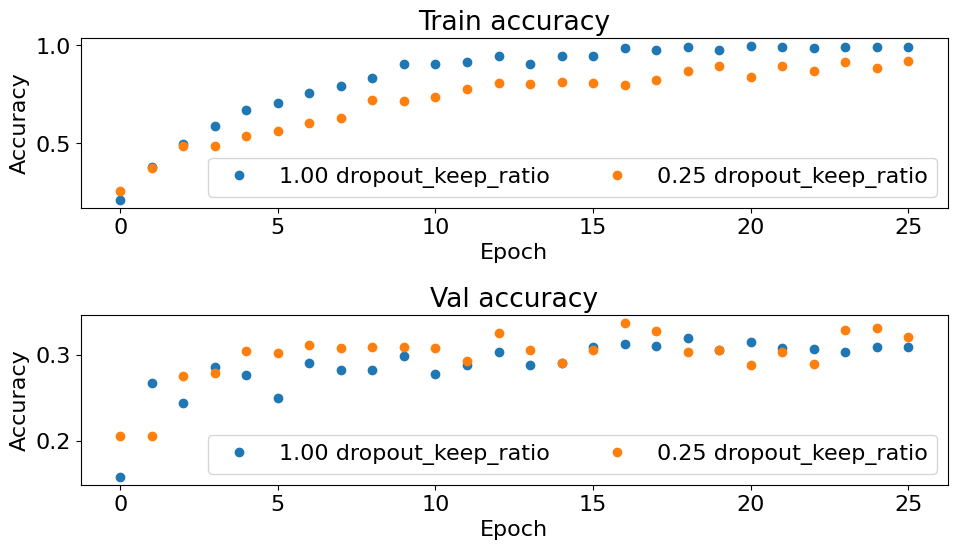

In [35]:
train_accs = []
val_accs = []
for dropout_keep_ratio in dropout_choices:
    solver = solvers[dropout_keep_ratio]
    train_accs.append(solver.train_acc_history[-1])
    val_accs.append(solver.val_acc_history[-1])

plt.subplot(3, 1, 1)
for dropout_keep_ratio in dropout_choices:
    plt.plot(
        solvers[dropout_keep_ratio].train_acc_history, 'o', label='%.2f dropout_keep_ratio' % dropout_keep_ratio)
plt.title('Train accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(ncol=2, loc='lower right')
  
plt.subplot(3, 1, 2)
for dropout_keep_ratio in dropout_choices:
    plt.plot(
        solvers[dropout_keep_ratio].val_acc_history, 'o', label='%.2f dropout_keep_ratio' % dropout_keep_ratio)
plt.title('Val accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(ncol=2, loc='lower right')

plt.tight_layout()
plt.show()

## Batch Normalization (BN)
- **Your task #19**: Implement the **training-time forward pass** for BN. Use minibatch statistics to compute the mean and variance, use these statistics to normalize the incoming data, and scale and shift the normalized data using gamma and beta. You should store the output in the variable out. Any intermediates that you need for the backward pass should be stored in the cache variable. You should also use your computed sample mean and variance together with the momentum variable to update the running mean and running variance, storing your result in the running_mean and running_var variables. Note that though you should be keeping track of the running variance, you should normalize the data based on the standard deviation (square root of variance) instead.
- **Your task #20**: Implement **test-time forward pass** for BN. Use the running mean and variance to normalize the incoming data, then scale and shift the normalized data using gamma and beta. Store the result in the out variable. 

In [36]:
def batchnorm_forward(x, gamma, beta, bn_param):
    """Forward pass for batch normalization.

    During training the sample mean and (uncorrected) sample variance are
    computed from minibatch statistics and used to normalize the incoming data.
    During training we also keep an exponentially decaying running mean of the
    mean and variance of each feature, and these averages are used to normalize
    data at test-time.

    At each timestep we update the running averages for mean and variance using
    an exponential decay based on the momentum parameter:

    running_mean = momentum * running_mean + (1 - momentum) * sample_mean
    running_var = momentum * running_var + (1 - momentum) * sample_var

    Note that the batch normalization paper suggests a different test-time
    behavior: they compute sample mean and variance for each feature using a
    large number of training images rather than using a running average. For
    this implementation we have chosen to use running averages instead since
    they do not require an additional estimation step; the torch7
    implementation of batch normalization also uses running averages.

    Input:
    - x: Data of shape (N, D)
    - gamma: Scale parameter of shape (D,)
    - beta: Shift paremeter of shape (D,)
    - bn_param: Dictionary with the following keys:
      - mode: 'train' or 'test'; required
      - eps: Constant for numeric stability
      - momentum: Constant for running mean / variance.
      - running_mean: Array of shape (D,) giving running mean of features
      - running_var Array of shape (D,) giving running variance of features

    Returns a tuple of:
    - out: of shape (N, D)
    - cache: A tuple of values needed in the backward pass
    """
    mode = bn_param["mode"]
    eps = bn_param.get("eps", 1e-5)
    momentum = bn_param.get("momentum", 0.9)

    N, D = x.shape
    running_mean = bn_param.get("running_mean", torch.zeros(D, dtype=x.dtype))
    running_var = bn_param.get("running_var", torch.zeros(D, dtype=x.dtype))

    out, cache = None, None
    if mode == "train":
        # Your task #19
        # *****START OF YOUR CODE (DO NOT DELETE/MODIFY THIS LINE)*****
        sample_mean = x.mean(dim=0)
        sample_var = x.var(dim=0, unbiased=False)

        # Normalize
        x_normalized = (x - sample_mean) / torch.sqrt(sample_var + eps)
        out = gamma * x_normalized + beta

        # Update running statistics
        running_mean = momentum * running_mean + (1 - momentum) * sample_mean
        running_var = momentum * running_var + (1 - momentum) * sample_var

        # Store intermediate values for backward pass
        cache = (x, x_normalized, gamma, beta, sample_mean, sample_var, eps)
        
        # *****END OF YOUR CODE (DO NOT DELETE/MODIFY THIS LINE)*****
    elif mode == "test":
        # Your task #20
        # *****START OF YOUR CODE (DO NOT DELETE/MODIFY THIS LINE)*****
        x_normalized = (x - running_mean) / torch.sqrt(running_var + eps)
        out = gamma * x_normalized + beta
        # *****END OF YOUR CODE (DO NOT DELETE/MODIFY THIS LINE)*****
    else:
        raise ValueError('Invalid forward batchnorm mode "%s"' % mode)

    # Store the updated running means back into bn_param
    bn_param["running_mean"] = running_mean
    bn_param["running_var"] = running_var

    return out, cache

- Check the training-time forward pass by checking means and variances of features both before and after batch normalization   

In [37]:
def print_mean_std(x,axis=0):
    print(f"  means: {x.mean(axis=axis)}")
    print(f"  stds:  {x.std(axis=axis)}\n")

In [38]:
np.random.seed(3201)
N, D1, D2, D3 = 200, 50, 60, 3
X = torch.randn(N, D1)
W1 = torch.randn(D1, D2)
W2 = torch.randn(D2, D3)
a = torch.relu(X.mm(W1)).mm(W2)

print('Before batch normalization:')
print_mean_std(a, axis=0)

gamma = torch.ones((D3,))
beta = torch.zeros((D3,))

# Means should be close to zero and stds close to one.
print('After batch normalization (gamma=1, beta=0)')
a_norm, _ = batchnorm_forward(a, gamma, beta, {'mode': 'train'})
print_mean_std(a_norm,axis=0)

gamma = torch.Tensor([1.0, 2.0, 3.0])
beta = torch.Tensor([11.0, 12.0, 13.0])

# Now means should be close to beta and stds close to gamma.
print('After batch normalization (gamma=', gamma, ', beta=', beta, ')')
a_norm, _ = batchnorm_forward(a, gamma, beta, {'mode': 'train'})
print_mean_std(a_norm,axis=0)

Before batch normalization:
  means: tensor([ -4.3113,  32.7918, -38.5192])
  stds:  tensor([29.9811, 33.4791, 31.5986])

After batch normalization (gamma=1, beta=0)
  means: tensor([ 8.9407e-09, -7.0333e-08, -5.0068e-08])
  stds:  tensor([1.0025, 1.0025, 1.0025])

After batch normalization (gamma= tensor([1., 2., 3.]) , beta= tensor([11., 12., 13.]) )
  means: tensor([11., 12., 13.])
  stds:  tensor([1.0025, 2.0050, 3.0075])



- Check the test-time forward pass by running the training-time forward pass many times to warm up the running averages.
- Then, checking the means and variances of activations after a test-time forward pass.

In [39]:
np.random.seed(3201)
N, D1, D2, D3 = 200, 50, 60, 3
W1 = torch.randn(D1, D2)
W2 = torch.randn(D2, D3)

bn_param = {'mode': 'train'}
gamma = torch.ones(D3)
beta = torch.zeros(D3)

for t in range(50):
  X = torch.randn(N, D1)
  a = torch.relu(X.mm(W1)).mm(W2)
  batchnorm_forward(a, gamma, beta, bn_param)

bn_param['mode'] = 'test'
X = torch.randn(N, D1)
a = torch.relu(X.mm(W1)).mm(W2)
a_norm, _ = batchnorm_forward(a, gamma, beta, bn_param)

# Means should be close to zero and stds close to one, but will be
# noisier than training-time forward passes.
print('After batch normalization (test-time):')
print_mean_std(a_norm,axis=0)

After batch normalization (test-time):
  means: tensor([-0.0825,  0.1062, -0.0044])
  stds:  tensor([0.9898, 0.9230, 0.9215])



- **Your task #21**: Implement the backward pass for BN. Store the results in the dx, dgamma, and dbeta variables.  

In [40]:
def batchnorm_backward(dout, cache):
    """Backward pass for batch normalization.

    For this implementation, you should write out a computation graph for
    batch normalization on paper and propagate gradients backward through
    intermediate nodes.

    Inputs:
    - dout: Upstream derivatives, of shape (N, D)
    - cache: Variable of intermediates from batchnorm_forward.

    Returns a tuple of:
    - dx: Gradient with respect to inputs x, of shape (N, D)
    - dgamma: Gradient with respect to scale parameter gamma, of shape (D,)
    - dbeta: Gradient with respect to shift parameter beta, of shape (D,)
    """
    dx, dgamma, dbeta = None, None, None

    # Your task #21
    # *****START OF YOUR CODE (DO NOT DELETE/MODIFY THIS LINE)*****
    # Unpack cache
    x, x_normalized, gamma, beta, sample_mean, sample_var, eps = cache
    N, D = dout.shape

    # Step 1: Gradients of loss w.r.t beta and gamma
    dbeta = dout.sum(dim=0)
    dgamma = (dout * x_normalized).sum(dim=0)

    # Step 2: Gradient w.r.t x_normalized
    dx_normalized = dout * gamma

    # Step 3: Gradient w.r.t sample variance
    dvar = (dx_normalized * (x - sample_mean) * -0.5 * (sample_var + eps) ** (-1.5)).sum(dim=0)

    # Step 4: Gradient w.r.t sample mean
    dmean = (dx_normalized * -1 / torch.sqrt(sample_var + eps)).sum(dim=0) + dvar * (-2 * (x - sample_mean).sum(dim=0) / N)

    # Step 5: Gradient w.r.t input x
    dx = dx_normalized / torch.sqrt(sample_var + eps) + dvar * 2 * (x - sample_mean) / N + dmean / N

    # *****END OF YOUR CODE (DO NOT DELETE/MODIFY THIS LINE)*****

    return dx, dgamma, dbeta

### Incorporating BN into DNN
- **Your task #22**: modify `generic_forward` to use dropout. Specifically, if `bn_param` is not None, then `batchnorm_forward` should be conducted

In [41]:
def generic_forward(x, w, b, gamma=None, beta=None, bn_param=None, dropout_param=None, last=False):
    """Convenience layer with linear layer, BN if needed, ReLU, and dropout if needed

    Inputs:
    - x: Input to the linear layer
    - w, b: Weights for the linear layer
    - gamma, beta: Scale and shift params for BN
    - bn_param: Dictionary of required BN parameters
    - dropout_param: Dictionary of required Dropout parameters
    - last: Indicates wether to perform just affine forward

    Returns a tuple of:
    - out: Output from the ReLU or Dropout
    - cache: Object to give to the backward pass
    """
    # Initialize optional caches to None
    bn_cache, relu_cache, dropout_cache = None, None, None

    # Linear forward is a must
    out, fc_cache = linear_forward(x, w, b)

    # If the the layer is not last
    if not last:
        # Your task #22
        # *****START OF YOUR CODE (DO NOT DELETE/MODIFY THIS LINE)*****
        # Batch Normalization
        if bn_param is not None:
            out, bn_cache = batchnorm_forward(out, gamma, beta, bn_param)
        
        # ReLU activation
        out, relu_cache = relu_forward(out)

        # Dropout
        if dropout_param is not None:
            out, dropout_cache = dropout_forward(out, dropout_param)

        # *****END OF YOUR CODE (DO NOT DELETE/MODIFY THIS LINE)*****
        
    # Prepare cache for backward pass
    cache = fc_cache, bn_cache, relu_cache, dropout_cache

    return out, cache

- **Your task #23**: modify `generic_backward` to use dropout. Specifically, if `bn_cache` is not None, then `batchnorm_backward` should be conducted

In [42]:
def generic_backward(dout, cache):
    """Backward pass for the linear-bn-relu-dropout convenience layer.
    """
    # Init norm params to None
    dgamma, dbeta = None, None

    # Get the prapared caches from the forward pass
    fc_cache, bn_cache, relu_cache, dropout_cache = cache

    # Your task #23
    # *****START OF YOUR CODE (DO NOT DELETE/MODIFY THIS LINE)*****
    # Dropout backward
    if dropout_cache is not None:
        dout = dropout_backward(dout, dropout_cache)

    # ReLU backward
    if relu_cache is not None:
        dout = relu_backward(dout, relu_cache)

    # Batch normalization backward
    if bn_cache is not None:
        dout, dgamma, dbeta = batchnorm_backward(dout, bn_cache)
        
    # *****END OF YOUR CODE (DO NOT DELETE/MODIFY THIS LINE)*****
    
    # Linear backward is a must
    dx, dw, db = linear_backward(dout, fc_cache)

    return dx, dw, db, dgamma, dbeta

- **Your task #24 (Initialization)**: In addition to the implementation of the initialization in task #xx, implementing BN. Specifically, store scale and shift parameters for the first layer in gamma1 and beta1; for the second layer use gamma2 and beta2, etc. Scale parameters should be initialized to ones and shift parameters should be initialized to zeros.
- **Your task #25 (Forward)**: In addition to the implementation of the forward in task #xx, implementing BN. Specifically, you'll need to pass self.bn_params[0] to the forward pass for the first batch normalization layer, pass self.bn_params[1] to the forward pass for the second batch normalization layer, etc.                                                              
- **Your task #26 (Backward)**: In addition to the implementation of the backward in task #xx, implementing BN. Specifically, you don't need to regularize the scale and shift parameters.

In [43]:
class FullyConnectedNet(object):
    """Class for a multi-layer fully connected neural network.

    Network contains an arbitrary number of hidden layers, ReLU nonlinearities,
    and a softmax loss function. This will also implement dropout and batch
    normalization as options. For a network with L layers, the architecture will be

    {Linear - [batch norm] - relu - [dropout]} x (L - 1) - Linear - softmax

    where batch normalization and dropout are optional and the {...} block is
    repeated L - 1 times.

    Learnable parameters are stored in the self.params dictionary and will be learned
    using the Solver class.
    """

    def __init__(
        self,
        hidden_dims,
        input_dim=3 * 32 * 32 + 1,
        num_classes=10,
        dropout_keep_ratio=1,
        normalization=None,
        reg=0.0,
        weight_scale=1e-2,
        dtype=np.float32,
        seed=None,
    ):
        """Initialize a new FullyConnectedNet.

        Inputs:
        - hidden_dims: A list of integers giving the size of each hidden layer.
        - input_dim: An integer giving the size of the input.
        - num_classes: An integer giving the number of classes to classify.
        - dropout_keep_ratio: Scalar between 0 and 1 giving dropout strength.
            If dropout_keep_ratio=1 then the network should not use dropout at all.
        - normalization: What type of normalization the network should use. Valid values
            are "batchnorm", or None for no normalization (the default).
        - reg: Scalar giving L2 regularization strength.
        - weight_scale: Scalar giving the standard deviation for random
            initialization of the weights.
        - dtype: A numpy datatype object; all computations will be performed using
            this datatype. float32 is faster but less accurate, so you should use
            float64 for numeric gradient checking.
        - seed: If not None, then pass this random seed to the dropout layers.
            This will make the dropout layers deteriminstic so we can gradient check the model.
        """
        self.normalization = normalization
        self.use_dropout = dropout_keep_ratio != 1
        self.reg = reg
        self.num_layers = 1 + len(hidden_dims)
        self.dtype = dtype
        self.params = {}

        # Your task #24
        # *****START OF YOUR CODE (DO NOT DELETE/MODIFY THIS LINE)*****
        # Initialize the layer parameters
        layer_dims = [input_dim] + hidden_dims + [num_classes]
        for i in range(self.num_layers):
            self.params[f"W{i + 1}"] = torch.randn(layer_dims[i], layer_dims[i + 1]) * weight_scale
            self.params[f"b{i + 1}"] = torch.zeros(layer_dims[i + 1])

            if self.normalization == "batchnorm" and i < self.num_layers - 1:
                self.params[f"gamma{i + 1}"] = torch.ones(layer_dims[i + 1])
                self.params[f"beta{i + 1}"] = torch.zeros(layer_dims[i + 1])
                
        # *****END OF YOUR CODE (DO NOT DELETE/MODIFY THIS LINE)*****

        # When using dropout we need to pass a dropout_param dictionary to each
        # dropout layer so that the layer knows the dropout probability and the mode
        # (train / test). You can pass the same dropout_param to each dropout layer.
        self.dropout_param = {}
        if self.use_dropout:
            self.dropout_param = {"mode": "train", "p": dropout_keep_ratio}
            if seed is not None:
                self.dropout_param["seed"] = seed

        # With batch normalization we need to keep track of running means and
        # variances, so we need to pass a special bn_param object to each batch
        # normalization layer. You should pass self.bn_params[0] to the forward pass
        # of the first batch normalization layer, self.bn_params[1] to the forward
        # pass of the second batch normalization layer, etc.
        self.bn_params = []
        if self.normalization == "batchnorm":
            self.bn_params = [{"mode": "train"} for i in range(self.num_layers - 1)]
        if self.normalization == "layernorm":
            self.bn_params = [{} for i in range(self.num_layers - 1)]

    def loss(self, X, y=None):
        """Compute loss and gradient for the fully connected net.
        
        Inputs:
        - X: Array of input data of shape (N, d_1, ..., d_k)
        - y: Array of labels, of shape (N,). y[i] gives the label for X[i].

        Returns:
        If y is None, then run a test-time forward pass of the model and return:
        - scores: Array of shape (N, C) giving classification scores, where
            scores[i, c] is the classification score for X[i] and class c.

        If y is not None, then run a training-time forward and backward pass and
        return a tuple of:
        - loss: Scalar value giving the loss
        - grads: Dictionary with the same keys as self.params, mapping parameter
            names to gradients of the loss with respect to those parameters.
        """
        mode = "test" if y is None else "train"

        # Set train/test mode for batchnorm params and dropout param since they
        # behave differently during training and testing.
        if self.use_dropout:
            self.dropout_param["mode"] = mode
        if self.normalization == "batchnorm":
            for bn_param in self.bn_params:
                bn_param["mode"] = mode
        scores = None

        # Your task #25
        # *****START OF YOUR CODE (DO NOT DELETE/MODIFY THIS LINE)*****
        caches = []
        out = X
        for i in range(self.num_layers - 1):
            w, b = self.params[f"W{i + 1}"], self.params[f"b{i + 1}"]
            dropout_param = None
            if self.use_dropout:
                dropout_param = self.dropout_param

            gamma, beta = None, None
            bn_param = None
            if self.normalization == "batchnorm":
                gamma = self.params[f"gamma{i + 1}"]
                beta = self.params[f"beta{i + 1}"]
                bn_param = self.bn_params[i]
            out, cache = generic_forward(out, w, b, gamma, beta, bn_param, dropout_param)
            caches.append(cache)

        # Last layer (no BN or dropout)
        w_last, b_last = self.params[f"W{self.num_layers}"], self.params[f"b{self.num_layers}"]
        scores, cache_last = generic_forward(out, w_last, b_last, last=True)
        caches.append(cache_last)

        # *****END OF YOUR CODE (DO NOT DELETE/MODIFY THIS LINE)*****

        # If test mode return early.
        if mode == "test":
            return scores

        loss, grads = 0.0, {}
        
        # Your task #26
        # *****START OF YOUR CODE (DO NOT DELETE/MODIFY THIS LINE)*****
        # Compute softmax loss and L2 regularization loss
        data_loss, dscores = softmax_loss(scores, y)  # Use softmax_loss function
        reg_loss = 0.0
        for i in range(self.num_layers):
            reg_loss += torch.sum(self.params[f"W{i+1}"] ** 2)  # L2 regularization on weights

        # Total loss
        loss = data_loss + 0.5 * self.reg * reg_loss

        # Backprop for the last layer
        dout, dw, db, _, _ = generic_backward(dscores, caches[-1])
        grads[f"W{self.num_layers}"] = dw + self.reg * self.params[f"W{self.num_layers}"]
        grads[f"b{self.num_layers}"] = db

        # Backprop for the rest of the layers
        for i in range(self.num_layers - 2, -1, -1):
            dout, dw, db, dgamma, dbeta = generic_backward(dout, caches[i])
            grads[f"W{i + 1}"] = dw + self.reg * self.params[f"W{i + 1}"]
            grads[f"b{i + 1}"] = db
            if self.normalization == "batchnorm":
                grads[f"gamma{i + 1}"] = dgamma
                grads[f"beta{i + 1}"] = dbeta

        # *****END OF YOUR CODE (DO NOT DELETE/MODIFY THIS LINE)*****

        return loss, grads

### Experiment
Run the following to train 6-layer network on a subset of 1000 training examples both with and without batch normalization.

In [44]:
np.random.seed(3201)

# Try training a very deep net with batchnorm.
hidden_dims = [100, 100, 100, 100, 100]

num_train = 1000
small_data = {
  'X_train': data['X_train'][:num_train],
  'y_train': data['y_train'][:num_train],
  'X_val': data['X_val'],
  'y_val': data['y_val'],
}

weight_scale = 2e-2
bn_model = FullyConnectedNet(hidden_dims, weight_scale=weight_scale, normalization='batchnorm')
model = FullyConnectedNet(hidden_dims, weight_scale=weight_scale, normalization=None)

print('Solver with batch norm:')
bn_solver = Solver(bn_model, small_data,
                num_epochs=10, batch_size=50,
                update_rule=adam,
                optim_config={
                  'learning_rate': 1e-3,
                },
                verbose=True,print_every=20)
bn_solver.train()

print('\nSolver without batch norm:')
solver = Solver(model, small_data,
                num_epochs=10, batch_size=50,
                update_rule=adam,
                optim_config={
                  'learning_rate': 1e-3,
                },
                verbose=True, print_every=20)
solver.train()

Solver with batch norm:
(Iteration 1 / 200) loss: 2.300768


(Epoch 0 / 10) train acc: 0.099000; val_acc: 0.104000
(Epoch 1 / 10) train acc: 0.302000; val_acc: 0.235000
(Iteration 21 / 200) loss: 1.959268
(Epoch 2 / 10) train acc: 0.389000; val_acc: 0.283000
(Iteration 41 / 200) loss: 1.811762
(Epoch 3 / 10) train acc: 0.449000; val_acc: 0.305000
(Iteration 61 / 200) loss: 1.508736
(Epoch 4 / 10) train acc: 0.505000; val_acc: 0.296000
(Iteration 81 / 200) loss: 1.541535
(Epoch 5 / 10) train acc: 0.584000; val_acc: 0.299000
(Iteration 101 / 200) loss: 1.295082
(Epoch 6 / 10) train acc: 0.636000; val_acc: 0.321000
(Iteration 121 / 200) loss: 1.227924
(Epoch 7 / 10) train acc: 0.727000; val_acc: 0.331000
(Iteration 141 / 200) loss: 1.193823
(Epoch 8 / 10) train acc: 0.738000; val_acc: 0.330000
(Iteration 161 / 200) loss: 1.158600
(Epoch 9 / 10) train acc: 0.743000; val_acc: 0.335000
(Iteration 181 / 200) loss: 0.933433
(Epoch 10 / 10) train acc: 0.810000; val_acc: 0.318000

Solver without batch norm:
(Iteration 1 / 200) loss: 2.302760
(Epoch 0 / 10

- Run the following to visualize the results from two networks trained above. You should find that using batch normalization helps the network to converge much faster.

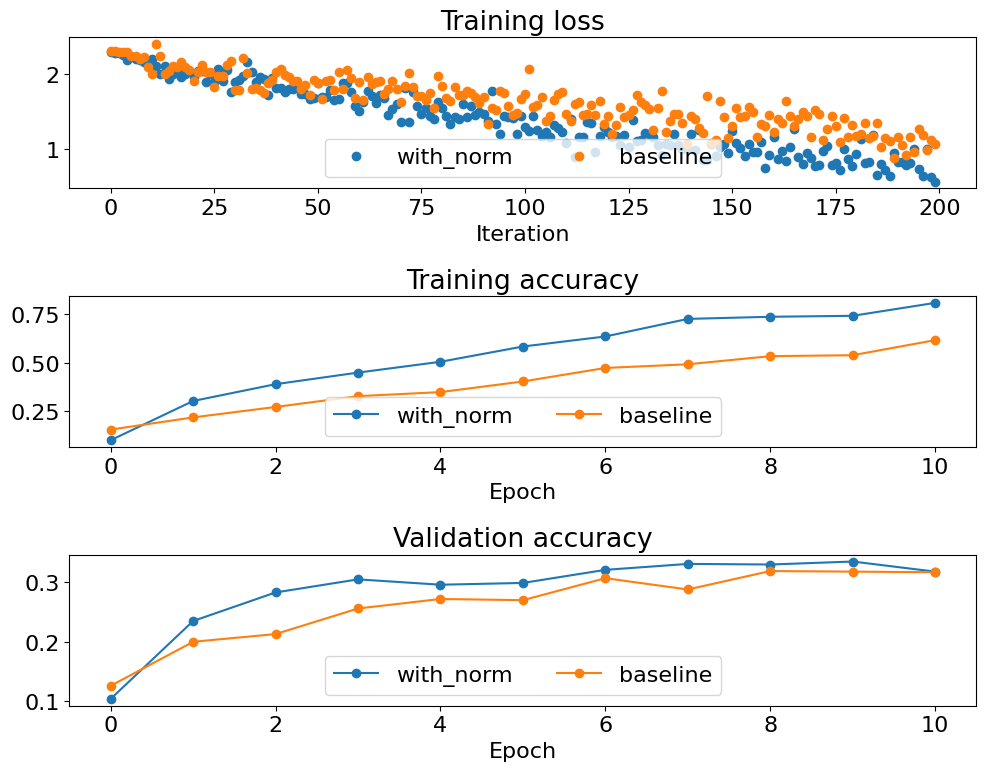

In [45]:
def plot_training_history(title, label, baseline, bn_solvers, plot_fn, bl_marker='.', bn_marker='.', labels=None):
    """utility function for plotting training history"""
    plt.title(title)
    plt.xlabel(label)
    bn_plots = [plot_fn(bn_solver) for bn_solver in bn_solvers]
    bl_plot = plot_fn(baseline)
    num_bn = len(bn_plots)
    for i in range(num_bn):
        label='with_norm'
        if labels is not None:
            label += str(labels[i])
        plt.plot(bn_plots[i], bn_marker, label=label)
    label='baseline'
    if labels is not None:
        label += str(labels[0])
    plt.plot(bl_plot, bl_marker, label=label)
    plt.legend(loc='lower center', ncol=num_bn+1) 

    
plt.subplot(3, 1, 1)
plot_training_history('Training loss','Iteration', solver, [bn_solver], \
                      lambda x: x.loss_history, bl_marker='o', bn_marker='o')
plt.subplot(3, 1, 2)
plot_training_history('Training accuracy','Epoch', solver, [bn_solver], \
                      lambda x: x.train_acc_history, bl_marker='-o', bn_marker='-o')
plt.subplot(3, 1, 3)
plot_training_history('Validation accuracy','Epoch', solver, [bn_solver], \
                      lambda x: x.val_acc_history, bl_marker='-o', bn_marker='-o')

plt.tight_layout()
plt.show()

# All together
- **Your task #27**: Train the best fully connected model that you can on CIFAR-10, storing your best model in the `best_model` variable. We require you to get **at least 50% accuracy on the validation set** using a fully connected network. If you are careful it should be possible to get accuracies above 55%, but we don't require it for this part and won't assign extra credit for doing so.
- **Hint**: for efficient hyper-parameter tuning, leveraging small trainset for this is important

In [ ]:
best_model = None

best_val = -1    # keep track of best validation accuracy
best_params = {} # dict to hold best model parameters
num_train = 500  # amount of training data for tests

# Generate small dataset
small_data = {
  "X_train": data["X_train"][:num_train],
  "y_train": data["y_train"][:num_train],
  "X_val": data["X_val"],
  "y_val": data["y_val"],
}

# Your task #27
# *****START OF YOUR CODE (DO NOT DELETE/MODIFY THIS LINE)*****
np.random.seed(27)
# Define ranges for hyperparameter tuning

import random

# Function to generate shuffled hidden dimensions with sizes as powers of 2
def generate_hidden_dims(num_layers, min_power=6, max_power=10):
    """
    Generate a list of hidden layer dimensions (powers of 2) with shuffled values.
    
    Args:
        num_layers (int): Number of layers.
        min_power (int): Minimum power of 2 (e.g., 2^6 = 64).
        max_power (int): Maximum power of 2 (e.g., 2^8 = 256).
        
    Returns:
        list: Hidden dimensions for each layer.
    """
    power_of_2_values = [2 ** p for p in range(min_power, max_power + 1)]
    hidden_dims = [random.choice(power_of_2_values) for _ in range(num_layers)]
    random.shuffle(hidden_dims)
    return hidden_dims

# Generate 15 candidates: 5 for 10 layers, 5 for 20 layers, and 5 for 40 layers
hidden_dims_candidates = (
    [generate_hidden_dims(10) for _ in range(3)] +  # 5 candidates with 10 layers
    [generate_hidden_dims(7) for _ in range(3)] +  # 5 candidates with 20 layers
    [generate_hidden_dims(5) for _ in range(3)]    # 5 candidates with 40 layers
)

# Print the candidates for verification
for i, dims in enumerate(hidden_dims_candidates, start=1):
    print(f"Candidate {i} ({len(dims)} layers): {dims}")


weight_scale_options = np.linspace(1e-4, 1e-3, 5) 
learning_rate_options = np.linspace(1e-4, 1e-3, 5)
# Hyperparameter tuning loop
for hidden_dims in hidden_dims_candidates:
    for weight_scale in weight_scale_options:
        for learning_rate in learning_rate_options:
            # Create the model with batch normalization
            model = FullyConnectedNet(hidden_dims, weight_scale=weight_scale, normalization='batchnorm')
            
            # Train the model using Solver with Adam optimizer
            solver = Solver(model, small_data,
                            num_epochs=20, batch_size=100,
                            update_rule=adam,
                            optim_config={
                              'learning_rate': learning_rate,
                            },
                            verbose=False)  # Suppress detailed logs for tuning
            solver.train()
            
            # Check if this model is the best so far
            if solver.best_val_acc > best_val:
                best_val = solver.best_val_acc
                best_params = {
                    'hidden_dims': hidden_dims,
                    'weight_scale': weight_scale,
                    'learning_rate': learning_rate
                }
                print(f"lr: {learning_rate}, ws: {weight_scale} ===> val_acc: {best_val}")

# Train best model with full dataset
best_model = FullyConnectedNet(hidden_dims=best_params['hidden_dims'],
                          weight_scale=best_params['weight_scale'],
                          normalization='normalization')

solver = Solver(best_model, data,
                num_epochs=20, batch_size=100,
                update_rule=adam,
                optim_config={
                'learning_rate': best_params['learning_rate'],
                },
                verbose=False)  # Suppress detailed logs for tuning

solver.train()
print(best_params)

# *****END OF YOUR CODE (DO NOT DELETE/MODIFY THIS LINE)*****

print(f'Best validation accuracy using full dataset: {solver.best_val_acc}')

Candidate 1 (10 layers): [128, 256, 64, 64, 64, 1024, 64, 256, 1024, 128]
Candidate 2 (10 layers): [512, 1024, 256, 128, 256, 128, 512, 256, 1024, 1024]
Candidate 3 (10 layers): [1024, 128, 128, 128, 1024, 256, 256, 64, 1024, 128]
Candidate 4 (7 layers): [1024, 1024, 64, 1024, 256, 64, 128]
Candidate 5 (7 layers): [64, 128, 128, 512, 64, 1024, 64]
Candidate 6 (7 layers): [64, 1024, 256, 128, 256, 64, 128]
Candidate 7 (5 layers): [128, 64, 1024, 64, 512]
Candidate 8 (5 layers): [64, 64, 64, 256, 256]
Candidate 9 (5 layers): [128, 1024, 256, 64, 64]
lr: 0.0001, ws: 0.0001 ===> val_acc: 0.1889999955892563
lr: 0.000325, ws: 0.0001 ===> val_acc: 0.19099999964237213
lr: 0.00055, ws: 0.0001 ===> val_acc: 0.25600001215934753
lr: 0.0001, ws: 0.00055 ===> val_acc: 0.2590000033378601
lr: 0.00055, ws: 0.00055 ===> val_acc: 0.2630000114440918
lr: 0.0001, ws: 0.0007750000000000001 ===> val_acc: 0.28600001335144043
lr: 0.0001, ws: 0.00055 ===> val_acc: 0.30799999833106995
lr: 0.001, ws: 0.000325 ===>

## Test Performance
- Run your best model on the validation and test sets. You should achieve at least 50% accuracy on the validation set.

In [54]:
y_test_pred = torch.argmax(best_model.loss(data['X_test']), dim=1)
y_val_pred = torch.argmax(best_model.loss(data['X_val']), dim=1)
print('Validation set accuracy: ', (y_val_pred == data['y_val']).float().mean().item())
print('Test set accuracy: ', (y_test_pred == data['y_test']).float().mean().item())

Validation set accuracy:  0.5490000247955322
Test set accuracy:  0.531000018119812
